In [11]:
import torch
import numpy as np
import os
import glob

# Base directory containing all output folders
base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/'

# List all output directories
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')))

# Initialize list to store all phis
all_phis = []

# Load phi from each model
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        # Load the saved model
        checkpoint = torch.load(model_path)
        
        # Extract phi - might need to adjust based on how it's stored
        if 'model_state_dict' in checkpoint:
            # If phi is in state dict
            phi = checkpoint['model_state_dict']['phi']
        else:
            # If phi is stored directly
            phi = checkpoint['phi']
            
        # Convert to numpy if it's a tensor
        if torch.is_tensor(phi):
            phi = phi.detach().cpu().numpy()
            
        all_phis.append(phi)
        print(f"Loaded phi from {dir_path}")
        
    except Exception as e:
        print(f"Error loading from {dir_path}: {e}")

# Convert list to numpy array
all_phis = np.array(all_phis)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_1831/148481545.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Loaded phi from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028
Loaded phi from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_100000_110000_20241225_225116
Loaded phi from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_10000_20000_20241225_062028
Loaded phi from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_110000_120000_20241225_225127
Loaded phi from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_120000_130000_20241226_020120
Loaded phi from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_130000_140000_20241226_020134
Loaded phi from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_140000_150000_20241226_051212
Loaded phi from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_150000_160000_20241226_051223
Loaded phi from /Users/sarahurbut/Dropbox (Personal)/fro

In [45]:
import os
import glob
import numpy as np
import torch
from scipy.special import softmax, expit

# Initialize storage for results
all_conditional_probs = []
all_cad_statuses = []
all_transitions = []
all_trajectory_stats = []

print("Starting processing...")

for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        print(f"\nProcessing {dir_path}")
        
        # Load the saved model
        checkpoint = torch.load(model_path)
        
        # Extract necessary components
        if 'model_state_dict' in checkpoint:
            lambda_values = checkpoint['model_state_dict']['lambda_']
            phi_values = checkpoint['model_state_dict']['phi']
        else:
            lambda_values = checkpoint['lambda_']
            phi_values = checkpoint['phi']
            
        if torch.is_tensor(lambda_values):
            lambda_values = lambda_values.detach().cpu().numpy()
        if torch.is_tensor(phi_values):
            phi_values = phi_values.detach().cpu().numpy()
            
        Y_batch = checkpoint['Y']
        if torch.is_tensor(Y_batch):
            Y_batch = Y_batch.detach().cpu().numpy()
            
        print(f"Lambda shape: {lambda_values.shape}")
        print(f"Phi shape: {phi_values.shape}")
        print(f"Y shape: {Y_batch.shape}")
        
        disease_names = checkpoint['disease_names']
        print(f"Available diseases: {disease_names}")
        
        # Find indices for both CAD conditions
        cad_indices = []
        for condition in ['Coronary atherosclerosis', 'Myocardial infarction']:
            try:
                idx = disease_names.index(condition)
                cad_indices.append(idx)
                print(f"Found {condition} at index: {idx}")
            except ValueError:
                print(f"Warning: {condition} not found in disease names")
        
        if not cad_indices:
            raise ValueError("Neither CAD condition found in disease names")
        
        time_x = 30  # Age 60
        future_window = 10  # Look ahead 2.5 years
        
        # Get CAD status before time_x (either condition)
        cad_before_x = np.zeros(Y_batch.shape[0], dtype=bool)
        for cad_idx in cad_indices:
            cad_before_x |= np.any(Y_batch[:, cad_idx, :time_x], axis=1)
        
        # Calculate thetas (trajectory memberships)
        thetas = softmax(lambda_values, axis=1)
        
        # Find dominant trajectory at time_x and future time for each individual
        dominant_trajectory_x = np.argmax(thetas[:, :, time_x], axis=1)
        dominant_trajectory_future = np.argmax(thetas[:, :, time_x + future_window], axis=1)
        
        # Store batch results
        batch_transitions = []
        batch_stats = []
        
        # Analyze each trajectory
        for k in range(thetas.shape[1]):  # for each trajectory
            # Get individuals with high loading (>0.5) on trajectory k at time_x
            high_loading_k = thetas[:, k, time_x] > 0.5
            
            if np.sum(high_loading_k) > 0:
                # Basic statistics
                n_individuals = np.sum(high_loading_k)
                
                # Calculate transition probabilities
                future_trajectories = dominant_trajectory_future[high_loading_k]
                transitions = np.bincount(future_trajectories, minlength=thetas.shape[1]) / len(future_trajectories)
                
                # Calculate CAD outcomes
                cad_risk = np.mean(cad_before_x[high_loading_k])
                
                # Track trajectory strength over time
                mean_loading = np.mean(thetas[high_loading_k, k, time_x:time_x+future_window], axis=0)
                
                # Store trajectory statistics
                trajectory_stats = {
                    'trajectory': k,
                    'n_individuals': n_individuals,
                    'cad_risk': cad_risk,
                    'mean_loading': mean_loading,
                    'transitions': transitions
                }
                
                # Get top diseases for this trajectory
                top_diseases = np.argsort(phi_values[k, :, time_x])[-5:]
                trajectory_stats['top_diseases'] = [(disease_names[idx], phi_values[k, idx, time_x]) 
                                                  for idx in top_diseases]
                
                batch_stats.append(trajectory_stats)
                batch_transitions.append(transitions)
                
                print(f"\nTrajectory {k} Analysis:")
                print(f"Number of individuals: {n_individuals}")
                print(f"CAD risk: {cad_risk:.3f}")
                print("\nTransition probabilities:")
                for j, prob in enumerate(transitions):
                    if prob > 0.05:  # Only show significant transitions
                        print(f"  To trajectory {j}: {prob:.3f}")
                
                print("\nTrajectory strength over time:")
                for t, strength in enumerate(mean_loading):
                    print(f"  Time {time_x + t}: {strength:.3f}")
                
                print("\nTop diseases in this trajectory:")
                for disease, phi_value in trajectory_stats['top_diseases']:
                    print(f"  {disease}: {phi_value:.3f}")
        
        all_transitions.append(batch_transitions)
        all_trajectory_stats.append(batch_stats)
        
    except Exception as e:
        print(f"Error processing {dir_path}: {str(e)}")
        print("Full error:")
        import traceback
        traceback.print_exc()

# Aggregate results across all batches
if len(all_trajectory_stats) > 0:
    print("\nOverall Summary:")
    
    # Calculate average statistics across batches
    n_trajectories = len(all_trajectory_stats[0])
    
    for k in range(n_trajectories):
        print(f"\nTrajectory {k} Summary:")
        
        # Aggregate statistics
        total_individuals = sum(batch[k]['n_individuals'] for batch in all_trajectory_stats)
        avg_cad_risk = np.mean([batch[k]['cad_risk'] for batch in all_trajectory_stats])
        
        print(f"Total individuals: {total_individuals}")
        print(f"Average CAD risk: {avg_cad_risk:.3f}")
        
        # Average transition probabilities
        avg_transitions = np.mean([batch[k]['transitions'] for batch in all_trajectory_stats], axis=0)
        print("\nAverage transition probabilities:")
        for j, prob in enumerate(avg_transitions):
            if prob > 0.05:
                print(f"  To trajectory {j}: {prob:.3f}")
        
        # Most common diseases (using first batch as representative)
        print("\nCharacteristic diseases:")
        for disease, phi_value in all_trajectory_stats[0][k]['top_diseases']:
            print(f"  {disease}: {phi_value:.3f}")
else:
    print("No data was processed successfully!")

Starting processing...

Processing /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028
Lambda shape: (10000, 20, 52)
Phi shape: (20, 348, 52)
Y shape: (10000, 348, 52)
Available diseases: [np.str_('Bacterial enteritis'), np.str_('Viral Enteritis'), np.str_('Gram negative septicemia'), np.str_('Bacterial infection NOS'), np.str_('Staphylococcus infections'), np.str_('Streptococcus infection'), np.str_('E. coli'), np.str_('Viral warts & HPV'), np.str_('Viral infection'), np.str_('Candidiasis'), np.str_('Colon cancer'), np.str_('Malignant neoplasm of rectum, rectosigmoid junction, and anus'), np.str_('Neoplasm of unspecified nature of digestive system'), np.str_('Cancer of bronchus; lung'), np.str_('Melanomas of skin'), np.str_('Other non-epithelial cancer of skin'), np.str_('Breast cancer [female]'), np.str_('Malignant neoplasm of female breast'), np.str_('Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]'), np.str_('Malignant neop

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_6481/470383245.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Lambda shape: (10000, 20, 52)
Phi shape: (20, 348, 52)
Y shape: (10000, 348, 52)
Available diseases: [np.str_('Bacterial enteritis'), np.str_('Viral Enteritis'), np.str_('Gram negative septicemia'), np.str_('Bacterial infection NOS'), np.str_('Staphylococcus infections'), np.str_('Streptococcus infection'), np.str_('E. coli'), np.str_('Viral warts & HPV'), np.str_('Viral infection'), np.str_('Candidiasis'), np.str_('Colon cancer'), np.str_('Malignant neoplasm of rectum, rectosigmoid junction, and anus'), np.str_('Neoplasm of unspecified nature of digestive system'), np.str_('Cancer of bronchus; lung'), np.str_('Melanomas of skin'), np.str_('Other non-epithelial cancer of skin'), np.str_('Breast cancer [female]'), np.str_('Malignant neoplasm of female breast'), np.str_('Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]'), np.str_('Malignant neoplasm of uterus'), np.str_('Malignant neoplasm of ovary'), np.str_('Cancer of prostate'), np.str_('Malignant neoplasm of kidney, exce

In [46]:
import os
import glob
import numpy as np
import torch
from scipy.special import softmax, expit

# Initialize storage for phi values
all_phi_values = []
disease_names = None

print("Starting processing...")

# First pass: collect all phi values
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        print(f"\nLoading data from {dir_path}")
        
        checkpoint = torch.load(model_path)
        
        # Extract and convert phi values
        if 'model_state_dict' in checkpoint:
            phi_values = checkpoint['model_state_dict']['phi']
        else:
            phi_values = checkpoint['phi']
            
        if torch.is_tensor(phi_values):
            phi_values = phi_values.detach().cpu().numpy()
            
        # Store disease names from first batch
        if disease_names is None:
            disease_names = checkpoint['disease_names']
            
        # Append to list
        all_phi_values.append(phi_values)
        
    except Exception as e:
        print(f"Error processing {dir_path}: {str(e)}")
        continue

# Compare phi values across batches
if len(all_phi_values) > 1:
    print("\nComparing phi values across batches...")
    
    # Calculate pairwise correlations and differences
    n_batches = len(all_phi_values)
    for i in range(n_batches):
        for j in range(i+1, n_batches):
            # Correlation
            corr = np.corrcoef(all_phi_values[i].flatten(), all_phi_values[j].flatten())[0,1]
            
            # Mean absolute difference
            mad = np.mean(np.abs(all_phi_values[i] - all_phi_values[j]))
            
            # Maximum absolute difference
            max_diff = np.max(np.abs(all_phi_values[i] - all_phi_values[j]))
            
            print(f"\nBatch {i} vs Batch {j}:")
            print(f"Correlation: {corr:.6f}")
            print(f"Mean absolute difference: {mad:.6f}")
            print(f"Maximum absolute difference: {max_diff:.6f}")
            
            # If differences are large, show where they occur
            if max_diff > 0.1:  # threshold for "significant" difference
                large_diffs = np.where(np.abs(all_phi_values[i] - all_phi_values[j]) > 0.1)
                print("\nLargest differences occur at:")
                for idx in zip(*large_diffs):
                    print(f"Trajectory {idx[0]}, Disease {disease_names[idx[1]]}, Time {idx[2]}")
                    print(f"Batch {i} value: {all_phi_values[i][idx]:.3f}")
                    print(f"Batch {j} value: {all_phi_values[j][idx]:.3f}")
    
    # If they're very similar, we can use the average
    if all(np.mean(np.abs(all_phi_values[0] - phi)) < 0.01 for phi in all_phi_values[1:]):
        print("\nPhi values are very similar across batches (mean absolute difference < 0.01)")
        print("Safe to use average or first batch phi values for analysis")
    else:
        print("\nWarning: Notable differences in phi values across batches")
        
else:
    print("Need at least two batches to compare!")

Starting processing...

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_100000_110000_20241225_225116


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_6481/450648821.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)



Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_10000_20000_20241225_062028

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_110000_120000_20241225_225127

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_120000_130000_20241226_020120

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_130000_140000_20241226_020134

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_140000_150000_20241226_051212

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_150000_160000_20241226_051223

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_160000_170000_20241226_082535

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_170000_180000_20241226_082558

Loading data from /Users/

In [47]:
import os
import glob
import numpy as np
import torch
from scipy.special import softmax, expit

# Initialize storage for combined data
all_lambda_values = []
all_Y_values = []
phi_values = None
disease_names = None

print("Starting processing...")

# Load and combine data
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        print(f"\nLoading data from {dir_path}")
        
        checkpoint = torch.load(model_path)
        
        # Extract lambda values and Y
        if 'model_state_dict' in checkpoint:
            lambda_values = checkpoint['model_state_dict']['lambda_']
            # Only get phi from first batch
            if phi_values is None:
                phi_values = checkpoint['model_state_dict']['phi']
        else:
            lambda_values = checkpoint['lambda_']
            if phi_values is None:
                phi_values = checkpoint['phi']
            
        # Convert to numpy if needed
        if torch.is_tensor(lambda_values):
            lambda_values = lambda_values.detach().cpu().numpy()
        if torch.is_tensor(phi_values):
            phi_values = phi_values.detach().cpu().numpy()
            
        Y_batch = checkpoint['Y']
        if torch.is_tensor(Y_batch):
            Y_batch = Y_batch.detach().cpu().numpy()
        
        # Store disease names from first batch
        if disease_names is None:
            disease_names = checkpoint['disease_names']
            
        # Append to lists
        all_lambda_values.append(lambda_values)
        all_Y_values.append(Y_batch)
        
    except Exception as e:
        print(f"Error processing {dir_path}: {str(e)}")
        continue

# Combine all data
if all_lambda_values:
    combined_lambda = np.concatenate(all_lambda_values, axis=0)
    combined_Y = np.concatenate(all_Y_values, axis=0)
    
    print("\nData loading complete!")
    print(f"Total samples: {combined_lambda.shape[0]}")
    print(f"Number of trajectories: {combined_lambda.shape[1]}")
    print(f"Number of timepoints: {combined_lambda.shape[2]}")
    print(f"Number of diseases: {len(disease_names)}")

Starting processing...

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_100000_110000_20241225_225116


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_6481/3653514571.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)



Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_10000_20000_20241225_062028

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_110000_120000_20241225_225127

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_120000_130000_20241226_020120

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_130000_140000_20241226_020134

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_140000_150000_20241226_051212

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_150000_160000_20241226_051223

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_160000_170000_20241226_082535

Loading data from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_170000_180000_20241226_082558

Loading data from /Users/

In [66]:
# For each CAD patient, get their dominant signature at time of diagnosis
dominant_sigs = []
max_thetas = []

for patient in np.where(cad_mask)[0]:
    # Find first CAD occurrence
    for cad_idx in cad_indices:
        if np.any(combined_Y[patient, cad_idx, :]):
            cad_time = np.argmax(combined_Y[patient, cad_idx, :])
            # Get dominant signature at that time
            dom_sig = np.argmax(thetas[patient, :, cad_time])
            max_theta = np.max(thetas[patient, :, cad_time])
            dominant_sigs.append(dom_sig)
            max_thetas.append(max_theta)
            break

# Count frequency of each signature
from collections import Counter
sig_counts = Counter(dominant_sigs)

print("Distribution of dominant signatures at CAD diagnosis:")
total = len(dominant_sigs)
for sig, count in sig_counts.most_common():
    print(f"\nSignature {sig}: {count} patients ({count/total*100:.1f}%)")
    print("Top diseases in this signature:")
    top_diseases = np.argsort(phi_avg[sig])[-5:]
    for idx in reversed(top_diseases):
        print(f"  {disease_names[idx]}: {phi_avg[sig, idx]:.3f}")

Distribution of dominant signatures at CAD diagnosis:

Signature 5: 3336 patients (7.8%)
Top diseases in this signature:
  Coronary atherosclerosis: 1.595
  Other chronic ischemic heart disease, unspecified: 1.550
  Myocardial infarction: 1.378
  Hypercholesterolemia: 1.185
  Other acute and subacute forms of ischemic heart disease: 0.864

Signature 15: 2281 patients (5.3%)
Top diseases in this signature:
  Hypoglycemia: 1.240
  Type 2 diabetes with ophthalmic manifestations: 1.108
  Type 2 diabetes: 0.983
  Back pain: 0.342
  Retinal detachments and defects: 0.009

Signature 16: 2195 patients (5.1%)
Top diseases in this signature:
  Staphylococcus infections: 1.687
  Other local infections of skin and subcutaneous tissue: 1.663
  Hyposmolality and/or hyponatremia: 1.597
  E. coli: 1.560
  Thrombocytopenia: 1.504

Signature 7: 2167 patients (5.1%)
Top diseases in this signature:
  Other disorders of bone and cartilage: 2.792
  Asthma: 2.307
  Cervicalgia: 2.054
  Sleep apnea: 1.925
  H

In [48]:
# Calculate thetas (trajectory memberships) from combined lambda
thetas = softmax(combined_lambda, axis=1)

# Analysis parameters
time_x = 30  # Age 60
future_window = 10  # Look ahead 2.5 years

# Find CAD indices
cad_indices = []
for condition in ['Coronary atherosclerosis', 'Myocardial infarction']:
    try:
        idx = disease_names.index(condition)
        cad_indices.append(idx)
        print(f"Found {condition} at index: {idx}")
    except ValueError:
        print(f"Warning: {condition} not found in disease names")

# Get CAD status before time_x
cad_before_x = np.zeros(combined_Y.shape[0], dtype=bool)
for cad_idx in cad_indices:
    cad_before_x |= np.any(combined_Y[:, cad_idx, :time_x], axis=1)

# Analyze each trajectory
n_trajectories = thetas.shape[1]
print(f"\nAnalyzing {n_trajectories} trajectories:")

for k in range(n_trajectories):
    # Get individuals with high loading on trajectory k at time_x
    high_loading_k = thetas[:, k, time_x] > 0.5
    n_individuals = np.sum(high_loading_k)
    
    if n_individuals > 0:
        # Calculate CAD risk
        cad_risk = np.mean(cad_before_x[high_loading_k])
        
        # Track trajectory strength over time
        mean_loading = np.mean(thetas[high_loading_k, k, time_x:time_x+future_window], axis=0)
        
        # Find future trajectories
        future_trajectories = np.argmax(thetas[high_loading_k, :, time_x + future_window], axis=1)
        transitions = np.bincount(future_trajectories, minlength=n_trajectories) / len(future_trajectories)
        
        print(f"\nTrajectory {k}:")
        print(f"Population size: {n_individuals} ({n_individuals/len(cad_before_x)*100:.1f}%)")
        print(f"CAD risk: {cad_risk:.3f}")
        
        # Show top diseases at current time
        print("\nCharacteristic diseases at time_x:")
        top_diseases = np.argsort(phi_values[k, :, time_x])[-5:]
        for idx in reversed(top_diseases):
            print(f"  {disease_names[idx]}: {phi_values[k, idx, time_x]:.3f}")
        
        # Show major transitions
        print("\nMajor transitions (>5%):")
        for j, prob in enumerate(transitions):
            if prob > 0.05:
                print(f"  To trajectory {j}: {prob:.3f}")
                if j != k:
                    # Show top diseases in destination trajectory
                    dest_diseases = np.argsort(phi_values[j, :, time_x + future_window])[-3:]
                    print("    Top diseases in destination trajectory:")
                    for idx in reversed(dest_diseases):
                        print(f"    {disease_names[idx]}: {phi_values[j, idx, time_x + future_window]:.3f}")
        
        # Show trajectory strength evolution
        print("\nTrajectory strength over time:")
        for t, strength in enumerate(mean_loading):
            print(f"  Time {time_x + t}: {strength:.3f}")

Found Coronary atherosclerosis at index: 114
Found Myocardial infarction at index: 112

Analyzing 20 trajectories:

Trajectory 0:
Population size: 191 (0.0%)
CAD risk: 0.037

Characteristic diseases at time_x:
  Abdominal pain: -4.541
  Atrial fibrillation and flutter: -5.066
  Paroxysmal ventricular tachycardia: -5.438
  Pleurisy; pleural effusion: -5.733
  Pericarditis: -6.094

Major transitions (>5%):
  To trajectory 0: 0.864
  To trajectory 13: 0.115
    Top diseases in destination trajectory:
    Hyperplasia of prostate: -4.120
    Other disorders of bladder: -4.950
    Cancer of prostate: -5.355

Trajectory strength over time:
  Time 30: 0.541
  Time 31: 0.538
  Time 32: 0.530
  Time 33: 0.517
  Time 34: 0.501
  Time 35: 0.482
  Time 36: 0.460
  Time 37: 0.435
  Time 38: 0.410
  Time 39: 0.383

Trajectory 1:
Population size: 243 (0.1%)
CAD risk: 0.041

Characteristic diseases at time_x:
  Other peripheral nerve disorders: -4.182
  Internal derangement of knee: -4.417
  Osteoarthr

In [52]:
# Load single checkpoint and get phi values and prevalence logits
model_path = os.path.join(output_dirs[0], 'model.pt')
checkpoint = torch.load(model_path)

# Extract phi and prevalence logits
if 'model_state_dict' in checkpoint:
    phi_values = checkpoint['model_state_dict']['phi']
else:
    phi_values = checkpoint['phi']

prevalence_logit = checkpoint['logit_prevalence_t']

# Convert to numpy if needed
if torch.is_tensor(phi_values):
    phi_values = phi_values.detach().cpu().numpy()
if torch.is_tensor(prevalence_logit):
    prevalence_logit = prevalence_logit.detach().cpu().numpy()

# Center phi values relative to prevalence logits
phi_centered = np.zeros_like(phi_values)
for k in range(phi_values.shape[0]):
    for d in range(phi_values.shape[1]):
        phi_centered[k, d, :] = phi_values[k, d, :] - prevalence_logit[d, :]

# Calculate average centered phi
phi_avg = phi_centered.mean(axis=2)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_6481/3593108353.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [61]:
# First check the range of theta values
print("Overall theta statistics:")
print(f"Min theta: {np.min(thetas):.3f}")
print(f"Max theta: {np.max(thetas):.3f}")
print(f"Mean theta: {np.mean(thetas):.3f}")

# Look at distribution of signature 5 values specifically
sig5_thetas = thetas[:, 5, :]
print("\nSignature 5 theta statistics:")
print(f"Min theta: {np.min(sig5_thetas):.3f}")
print(f"Max theta: {np.max(sig5_thetas):.3f}")
print(f"Mean theta: {np.mean(sig5_thetas):.3f}")

# Check a few individual CAD patients
cad_indices = [disease_names.index(d) for d in ['Coronary atherosclerosis', 'Myocardial infarction']]
cad_mask = np.zeros(combined_Y.shape[0], dtype=bool)
for cad_idx in cad_indices:
    cad_mask |= np.any(combined_Y[:, cad_idx, :], axis=1)

print("\nSample of individual CAD patients (signature 5 theta values):")
sample_patients = np.where(cad_mask)[0][:5]
for patient in sample_patients:
    print(f"\nPatient {patient}:")
    print(thetas[patient, 5, :])

Overall theta statistics:
Min theta: 0.000
Max theta: 0.897
Mean theta: 0.050

Signature 5 theta statistics:
Min theta: 0.000
Max theta: 0.873
Mean theta: 0.052

Sample of individual CAD patients (signature 5 theta values):

Patient 9:
[0.06689463 0.06515361 0.06283845 0.06007703 0.05699869 0.05372193
 0.05034612 0.04695016 0.04359633 0.04033837 0.03722684 0.03431246
 0.03164484 0.02926717 0.02721253 0.02550169 0.0241446  0.02314394
 0.02249951 0.02221152 0.02228368 0.02272427 0.02354611 0.02476522
 0.02639826 0.02845884 0.030953   0.03387463 0.03720137 0.04089195
 0.04488588 0.04910483 0.05345472 0.05782946 0.06211553 0.06619817
 0.06996925 0.07333699 0.07623468 0.07862316 0.0804918  0.08185023
 0.08272043 0.0831271  0.08309232 0.08263264 0.08175959 0.08048241
 0.07880972 0.07675268 0.07432777 0.07156136]

Patient 71:
[0.06816287 0.06977394 0.07156375 0.07348695 0.07549414 0.0775124
 0.07942726 0.08106467 0.08219616 0.0825551  0.08187583 0.07994623
 0.07665794 0.07204847 0.06630222 0.

In [62]:
# Get average theta values for signature 5 
cad_indices = [disease_names.index(d) for d in ['Coronary atherosclerosis', 'Myocardial infarction']]
cad_mask = np.zeros(combined_Y.shape[0], dtype=bool)
for cad_idx in cad_indices:
    cad_mask |= np.any(combined_Y[:, cad_idx, :], axis=1)

# Compare CAD vs non-CAD patients
cad_theta_5 = thetas[cad_mask, 5, :]
non_cad_theta_5 = thetas[~cad_mask, 5, :]

print("Signature 5 theta values:")
print(f"CAD patients mean: {np.mean(cad_theta_5):.3f}")
print(f"Non-CAD patients mean: {np.mean(non_cad_theta_5):.3f}")

Signature 5 theta values:
CAD patients mean: 0.061
Non-CAD patients mean: 0.051


In [64]:
# Check when CAD diagnoses typically occur
cad_times = []
for patient in np.where(cad_mask)[0]:
    for cad_idx in cad_indices:
        if np.any(combined_Y[patient, cad_idx, :]):
            first_cad = np.argmax(combined_Y[patient, cad_idx, :])
            cad_times.append(first_cad)

# Look at theta values around diagnosis time
window = 5  # Look 5 years before/after
theta_around_cad = []
for patient, cad_time in zip(np.where(cad_mask)[0], cad_times):
    if cad_time >= window and cad_time + window < combined_Y.shape[2]:
        theta_around_cad.append(thetas[patient, 5, cad_time-window:cad_time+window])

In [65]:
cad_times

[np.int64(46),
 np.int64(36),
 np.int64(37),
 np.int64(33),
 np.int64(32),
 np.int64(34),
 np.int64(35),
 np.int64(47),
 np.int64(27),
 np.int64(38),
 np.int64(40),
 np.int64(40),
 np.int64(28),
 np.int64(46),
 np.int64(44),
 np.int64(36),
 np.int64(37),
 np.int64(36),
 np.int64(34),
 np.int64(34),
 np.int64(9),
 np.int64(44),
 np.int64(26),
 np.int64(45),
 np.int64(50),
 np.int64(27),
 np.int64(27),
 np.int64(38),
 np.int64(27),
 np.int64(41),
 np.int64(41),
 np.int64(26),
 np.int64(26),
 np.int64(50),
 np.int64(30),
 np.int64(31),
 np.int64(31),
 np.int64(42),
 np.int64(45),
 np.int64(20),
 np.int64(29),
 np.int64(43),
 np.int64(36),
 np.int64(36),
 np.int64(47),
 np.int64(28),
 np.int64(27),
 np.int64(40),
 np.int64(25),
 np.int64(29),
 np.int64(48),
 np.int64(45),
 np.int64(45),
 np.int64(37),
 np.int64(37),
 np.int64(37),
 np.int64(37),
 np.int64(23),
 np.int64(20),
 np.int64(21),
 np.int64(21),
 np.int64(28),
 np.int64(28),
 np.int64(31),
 np.int64(30),
 np.int64(42),
 np.int64(4

In [59]:
# First identify people who develop CAD before age 60 (index 30)
early_age = 30
cad_indices = [disease_names.index(d) for d in ['Coronary atherosclerosis', 'Myocardial infarction']]

# Find first CAD occurrence for each person
early_cad_mask = np.zeros(combined_Y.shape[0], dtype=bool)
first_cad_time = np.full(combined_Y.shape[0], np.inf)

for cad_idx in cad_indices:
    has_cad = np.any(combined_Y[:, cad_idx, :early_age], axis=1)
    early_cad_mask |= has_cad
    # For those with CAD, find first occurrence
    cad_patients = np.where(has_cad)[0]
    for patient in cad_patients:
        onset = np.argmax(combined_Y[patient, cad_idx, :early_age])
        first_cad_time[patient] = min(first_cad_time[patient], onset)

print(f"Found {np.sum(early_cad_mask)} patients with CAD before age 60")

# For these patients:
# 1. What trajectory were they in 5 years before CAD?
# 2. What trajectory at CAD onset?
# 3. What trajectory 5 years after?

look_window = 5
trajectories_before = []
trajectories_at = []
trajectories_after = []

for patient in np.where(early_cad_mask)[0]:
    onset = int(first_cad_time[patient])
    if onset >= look_window and onset + look_window < combined_Y.shape[2]:
        # Get dominant trajectories at each timepoint
        traj_before = np.argmax(thetas[patient, :, onset-look_window])
        traj_at = np.argmax(thetas[patient, :, onset])
        traj_after = np.argmax(thetas[patient, :, onset+look_window])
        
        trajectories_before.append(traj_before)
        trajectories_at.append(traj_at)
        trajectories_after.append(traj_after)

# Analyze common patterns
from collections import Counter

print("\nMost common trajectories BEFORE CAD onset:")
for traj, count in Counter(trajectories_before).most_common(5):
    print(f"\nTrajectory {traj}: {count} patients ({count/len(trajectories_before)*100:.1f}%)")
    top_diseases = np.argsort(phi_avg[traj])[-5:]
    for idx in reversed(top_diseases):
        print(f"  {disease_names[idx]}: {phi_avg[traj, idx]:.3f}")

print("\nMost common trajectories AT CAD onset:")
for traj, count in Counter(trajectories_at).most_common(5):
    print(f"\nTrajectory {traj}: {count} patients ({count/len(trajectories_at)*100:.1f}%)")
    top_diseases = np.argsort(phi_avg[traj])[-5:]
    for idx in reversed(top_diseases):
        print(f"  {disease_names[idx]}: {phi_avg[traj, idx]:.3f}")

print("\nMost common trajectories AFTER CAD:")
for traj, count in Counter(trajectories_after).most_common(5):
    print(f"\nTrajectory {traj}: {count} patients ({count/len(trajectories_after)*100:.1f}%)")
    top_diseases = np.argsort(phi_avg[traj])[-5:]
    for idx in reversed(top_diseases):
        print(f"  {disease_names[idx]}: {phi_avg[traj, idx]:.3f}")

Found 11898 patients with CAD before age 60

Most common trajectories BEFORE CAD onset:

Trajectory 5: 1079 patients (9.1%)
  Coronary atherosclerosis: 1.595
  Other chronic ischemic heart disease, unspecified: 1.550
  Myocardial infarction: 1.378
  Hypercholesterolemia: 1.185
  Other acute and subacute forms of ischemic heart disease: 0.864

Trajectory 15: 671 patients (5.6%)
  Hypoglycemia: 1.240
  Type 2 diabetes with ophthalmic manifestations: 1.108
  Type 2 diabetes: 0.983
  Back pain: 0.342
  Retinal detachments and defects: 0.009

Trajectory 7: 624 patients (5.2%)
  Other disorders of bone and cartilage: 2.792
  Asthma: 2.307
  Cervicalgia: 2.054
  Sleep apnea: 1.925
  Hyperlipidemia: 1.748

Trajectory 11: 606 patients (5.1%)
  Hemiplegia: 3.584
  Cerebral artery occlusion, with cerebral infarction: 1.689
  Occlusion and stenosis of precerebral arteries: 1.478
  Occlusion of cerebral arteries: 0.772
  Transient cerebral ischemia: 0.634

Trajectory 8: 595 patients (5.0%)
  Malign

In [ ]:
# First identify people who develop CAD before age 60 (index 30)
early_age = 30
cad_indices = [disease_names.index(d) for d in ['Coronary atherosclerosis', 'Myocardial infarction']]

# Find first CAD occurrence for each person
early_cad_mask = np.zeros(combined_Y.shape[0], dtype=bool)
first_cad_time = np.full(combined_Y.shape[0], np.inf)

for cad_idx in cad_indices:
    has_cad = np.any(combined_Y[:, cad_idx, :early_age], axis=1)
    early_cad_mask |= has_cad
    # For those with CAD, find first occurrence
    cad_patients = np.where(has_cad)[0]
    for patient in cad_patients:
        onset = np.argmax(combined_Y[patient, cad_idx, :early_age])
        first_cad_time[patient] = min(first_cad_time[patient], onset)

print(f"Found {np.sum(early_cad_mask)} patients with CAD before age 60")

# For these patients:
# 1. What trajectory were they in 5 years before CAD?
# 2. What trajectory at CAD onset?
# 3. What trajectory 5 years after?

look_window = 5
trajectories_before = []
trajectories_at = []
trajectories_after = []

for patient in np.where(early_cad_mask)[0]:
    onset = int(first_cad_time[patient])
    if onset >= look_window and onset + look_window < combined_Y.shape[2]:
        # Get dominant trajectories at each timepoint
        traj_before = np.argmax(thetas[patient, :, onset-look_window])
        traj_at = np.argmax(thetas[patient, :, onset])
        traj_after = np.argmax(thetas[patient, :, onset+look_window])
        
        trajectories_before.append(traj_before)
        trajectories_at.append(traj_at)
        trajectories_after.append(traj_after)

# Analyze common patterns
from collections import Counter

print("\nMost common trajectories BEFORE CAD onset:")
for traj, count in Counter(trajectories_before).most_common(5):
    print(f"\nTrajectory {traj}: {count} patients ({count/len(trajectories_before)*100:.1f}%)")
    top_diseases = np.argsort(phi_avg[traj])[-5:]
    for idx in reversed(top_diseases):
        print(f"  {disease_names[idx]}: {phi_avg[traj, idx]:.3f}")

print("\nMost common trajectories AT CAD onset:")
for traj, count in Counter(trajectories_at).most_common(5):
    print(f"\nTrajectory {traj}: {count} patients ({count/len(trajectories_at)*100:.1f}%)")
    top_diseases = np.argsort(phi_avg[traj])[-5:]
    for idx in reversed(top_diseases):
        print(f"  {disease_names[idx]}: {phi_avg[traj, idx]:.3f}")

print("\nMost common trajectories AFTER CAD:")
for traj, count in Counter(trajectories_after).most_common(5):
    print(f"\nTrajectory {traj}: {count} patients ({count/len(trajectories_after)*100:.1f}%)")
    top_diseases = np.argsort(phi_avg[traj])[-5:]
    for idx in reversed(top_diseases):
        print(f"  {disease_names[idx]}: {phi_avg[traj, idx]:.3f}")

Found 11898 patients with CAD before age 60

Most common trajectories BEFORE CAD onset:

Trajectory 5: 1079 patients (9.1%)
  Coronary atherosclerosis: 1.595
  Other chronic ischemic heart disease, unspecified: 1.550
  Myocardial infarction: 1.378
  Hypercholesterolemia: 1.185
  Other acute and subacute forms of ischemic heart disease: 0.864

Trajectory 15: 671 patients (5.6%)
  Hypoglycemia: 1.240
  Type 2 diabetes with ophthalmic manifestations: 1.108
  Type 2 diabetes: 0.983
  Back pain: 0.342
  Retinal detachments and defects: 0.009

Trajectory 7: 624 patients (5.2%)
  Other disorders of bone and cartilage: 2.792
  Asthma: 2.307
  Cervicalgia: 2.054
  Sleep apnea: 1.925
  Hyperlipidemia: 1.748

Trajectory 11: 606 patients (5.1%)
  Hemiplegia: 3.584
  Cerebral artery occlusion, with cerebral infarction: 1.689
  Occlusion and stenosis of precerebral arteries: 1.478
  Occlusion of cerebral arteries: 0.772
  Transient cerebral ischemia: 0.634

Trajectory 8: 595 patients (5.0%)
  Malign

In [54]:


# Analyze transitions from Trajectory 5 (CAD cluster)
cad_traj = 5
time_x = 30  # Age 60

# Get individuals with high loading on trajectory 5 at time_x
high_loading_cad = thetas[:, cad_traj, time_x] > 0.5
n_individuals = np.sum(high_loading_cad)
n_trajectories=20

# Get their future trajectories
future_trajectories = np.argmax(thetas[high_loading_cad, :, time_x + future_window], axis=1)
transitions = np.bincount(future_trajectories, minlength=n_trajectories) / len(future_trajectories)

print(f"\nTransitions from CAD Trajectory (#{cad_traj}):")
print(f"Starting population: {n_individuals} individuals")

# Show major transitions and characteristic diseases of destination trajectories
for j, prob in enumerate(transitions):
    if prob > 0.05:  # Show transitions >5%
        print(f"\nTo Trajectory {j}: {prob:.3f}")
        # Get top diseases by centered phi for destination trajectory
        top_diseases = np.argsort(phi_avg[j])[-5:]
        print("Top diseases (centered phi):")
        for idx in reversed(top_diseases):
            print(f"  {disease_names[idx]}: {phi_avg[j, idx]:.3f}")


Transitions from CAD Trajectory (#5):
Starting population: 322 individuals

To Trajectory 5: 0.938
Top diseases (centered phi):
  Coronary atherosclerosis: 1.595
  Other chronic ischemic heart disease, unspecified: 1.550
  Myocardial infarction: 1.378
  Hypercholesterolemia: 1.185
  Other acute and subacute forms of ischemic heart disease: 0.864


In [55]:
# First get trajectories with high CAD-related diseases from phi_avg
cad_indices = []
for condition in ['Coronary atherosclerosis', 'Myocardial infarction']:
    try:
        idx = disease_names.index(condition)
        cad_indices.append(idx)
        print(f"Found {condition} at index: {idx}")
    except ValueError:
        print(f"Warning: {condition} not found in disease names")

# Find trajectories with high CAD loading
cad_related_trajectories = []
for k in range(n_trajectories):
    if any(phi_avg[k, idx] > 0 for idx in cad_indices):
        cad_related_trajectories.append(k)

print(f"\nFound {len(cad_related_trajectories)} trajectories with high CAD loading:")

# Analyze transitions from each CAD-related trajectory
time_x = 30  # Age 60
future_window = 10

for source_traj in cad_related_trajectories:
    # Get individuals with high loading on this trajectory at time_x
    high_loading = thetas[:, source_traj, time_x] > 0.5
    n_individuals = np.sum(high_loading)
    
    if n_individuals > 0:
        # Get their future trajectories
        future_trajectories = np.argmax(thetas[high_loading, :, time_x + future_window], axis=1)
        transitions = np.bincount(future_trajectories, minlength=n_trajectories) / len(future_trajectories)
        
        print(f"\n\nTransitions from Trajectory {source_traj}:")
        print(f"Starting population: {n_individuals} individuals")
        print(f"CAD-related phi values:")
        for idx in cad_indices:
            print(f"  {disease_names[idx]}: {phi_avg[source_traj, idx]:.3f}")
        
        # Show major transitions
        print("\nMajor transitions (>5%):")
        for j, prob in enumerate(transitions):
            if prob > 0.05:
                print(f"\nTo Trajectory {j}: {prob:.3f}")
                # Get top diseases by centered phi for destination trajectory
                top_diseases = np.argsort(phi_avg[j])[-5:]
                print("Top diseases (centered phi):")
                for idx in reversed(top_diseases):
                    print(f"  {disease_names[idx]}: {phi_avg[j, idx]:.3f}")

Found Coronary atherosclerosis at index: 114
Found Myocardial infarction at index: 112

Found 1 trajectories with high CAD loading:


Transitions from Trajectory 5:
Starting population: 322 individuals
CAD-related phi values:
  Coronary atherosclerosis: 1.595
  Myocardial infarction: 1.378

Major transitions (>5%):

To Trajectory 5: 0.938
Top diseases (centered phi):
  Coronary atherosclerosis: 1.595
  Other chronic ischemic heart disease, unspecified: 1.550
  Myocardial infarction: 1.378
  Hypercholesterolemia: 1.185
  Other acute and subacute forms of ischemic heart disease: 0.864


In [58]:
# For early CAD, let's look at ages 30-45 (indices 0-15)
early_time = 15  # Age 45
look_back = 5   # Look back 5 years (age 40)
look_forward = 5 # Look forward 5 years (age 50)

# Find people with early CAD (before age 45)
early_cad = np.zeros(combined_Y.shape[0], dtype=bool)
for cad_idx in cad_indices:
    early_cad |= np.any(combined_Y[:, cad_idx, :early_time], axis=1)

# Get trajectories at different time points
pre_cad_trajectories = np.argmax(thetas[early_cad, :, early_time-look_back], axis=1)  # Age 40
current_trajectories = np.argmax(thetas[early_cad, :, early_time], axis=1)  # Age 45
future_trajectories = np.argmax(thetas[early_cad, :, early_time+look_forward], axis=1)  # Age 50 2.5 years after

print("\nTrajectory progression for early CAD individuals:")
print("Before CAD -> At CAD -> After CAD")

# Count and show more progression patterns
from collections import Counter
progression_patterns = Counter(zip(pre_cad_trajectories, current_trajectories, future_trajectories))

# Show top 15 patterns and calculate percentage
total_early_cad = np.sum(early_cad)
for (pre, curr, post), count in progression_patterns.most_common(15):
    percentage = (count / total_early_cad) * 100
    print(f"\nProgression pattern (n={count}, {percentage:.1f}%):")
    print(f"Trajectory {pre} -> {curr} -> {post}")
    
    # Show diseases for pre-CAD trajectory to understand what came before
    print(f"\nPre-CAD Trajectory {pre} top diseases:")
    top_diseases = np.argsort(phi_avg[pre])[-5:]
    for idx in reversed(top_diseases):
        print(f"  {disease_names[idx]}: {phi_avg[pre, idx]:.3f}")
    
    # Show where they ended up
    print(f"\nFinal Trajectory {post} top diseases:")
    top_diseases = np.argsort(phi_avg[post])[-5:]
    for idx in reversed(top_diseases):
        print(f"  {disease_names[idx]}: {phi_avg[post, idx]:.3f}")

# Also show summary of initial trajectories
print("\nSummary of Pre-CAD Trajectories:")
pre_cad_counts = Counter(pre_cad_trajectories)
for traj, count in pre_cad_counts.most_common():
    percentage = (count / total_early_cad) * 100
    print(f"\nTrajectory {traj}: {count} individuals ({percentage:.1f}%)")
    top_diseases = np.argsort(phi_avg[traj])[-5:]
    for idx in reversed(top_diseases):
        print(f"  {disease_names[idx]}: {phi_avg[traj, idx]:.3f}")


Trajectory progression for early CAD individuals:
Before CAD -> At CAD -> After CAD

Progression pattern (n=41, 6.9%):
Trajectory 5 -> 5 -> 5

Pre-CAD Trajectory 5 top diseases:
  Coronary atherosclerosis: 1.595
  Other chronic ischemic heart disease, unspecified: 1.550
  Myocardial infarction: 1.378
  Hypercholesterolemia: 1.185
  Other acute and subacute forms of ischemic heart disease: 0.864

Final Trajectory 5 top diseases:
  Coronary atherosclerosis: 1.595
  Other chronic ischemic heart disease, unspecified: 1.550
  Myocardial infarction: 1.378
  Hypercholesterolemia: 1.185
  Other acute and subacute forms of ischemic heart disease: 0.864

Progression pattern (n=16, 2.7%):
Trajectory 16 -> 16 -> 16

Pre-CAD Trajectory 16 top diseases:
  Staphylococcus infections: 1.687
  Other local infections of skin and subcutaneous tissue: 1.663
  Hyposmolality and/or hyponatremia: 1.597
  E. coli: 1.560
  Thrombocytopenia: 1.504

Final Trajectory 16 top diseases:
  Staphylococcus infections: 

In [32]:

# Select some interesting diseases and signatures to plot
diseases_to_plot = [0, 1, 2]  # replace with actual disease indices of interest
signatures_to_plot = [0, 1, 2]  # replace with signatures of interest

# Create plots
for k in signatures_to_plot:
    for d in diseases_to_plot:
        plt.figure(figsize=(12, 6))
        
        # Plot individual batch trajectories in light gray
        for batch_phi in all_phis:
            plt.plot(batch_phi[k, d, :], color='gray', alpha=0.2)
        
        # Plot mean trajectory in bold
        plt.plot(mean_phi[k, d, :], color='blue', linewidth=2, label='Mean')
        
        # Add confidence intervals
        std_phi = np.std(all_phis[:, k, d, :], axis=0)
        ci = 1.96 * std_phi / np.sqrt(len(all_phis))
        plt.fill_between(range(mean_phi.shape[2]), 
                        mean_phi[k, d, :] - ci,
                        mean_phi[k, d, :] + ci,
                        alpha=0.2, color='blue')
        
        plt.title(f'Signature {k}, Disease {d} Temporal Pattern,unsharedseed')
        plt.xlabel('Time')
        plt.ylabel('Phi Value')
        plt.grid(True, alpha=0.3)
        plt.savefig(f'phi_trajectory_sig{k}_disease{d}_unshared.png')
        plt.close()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # for sigmoid function

# Select some interesting diseases and signatures to plot
diseases_to_plot = [0, 1, 2]  # replace with actual disease indices of interest
signatures_to_plot = [0, 1, 2]  # replace with signatures of interest

# Create plots
for k in signatures_to_plot:
    for d in diseases_to_plot:
        plt.figure(figsize=(12, 6))
        
        # Plot individual batch trajectories in light gray
        for batch_phi in all_phis:
            plt.plot(expit(batch_phi[k, d, :]), color='gray', alpha=0.2)
        
        # Plot mean trajectory in bold
        # Note: We should apply expit to individual values before taking mean
        mean_prob = expit(mean_phi[k, d, :])
        plt.plot(mean_prob, color='blue', linewidth=2, label='Mean')
        
        # For confidence intervals, transform the bounds
        std_phi = np.std(all_phis[:, k, d, :], axis=0)
        ci = 1.96 * std_phi / np.sqrt(len(all_phis))
        lower_ci = expit(mean_phi[k, d, :] - ci)
        upper_ci = expit(mean_phi[k, d, :] + ci)
        
        plt.fill_between(range(mean_phi.shape[2]), 
                        lower_ci,
                        upper_ci,
                        alpha=0.2, color='blue')
        
        plt.title(f'Signature {k}, Disease {d} Temporal Pattern (Probability),unsharedseed')
        plt.xlabel('Time')
        plt.ylabel('Probability')
        #plt.ylim(0, 1)  # Removed fixed y-axis limits
        plt.grid(True, alpha=0.3)
        plt.savefig(f'phi_probability_sig{k}_disease{d}_unshared.png')
        plt.close()

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/901596302.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(output_


Cluster 0 diseases:
------------------------
Top diseases (strongest in signature 14):
- Rheumatic disease of the heart valves: strength = -13.237 ± 0.897
- Disease of tricuspid valve: strength = -13.075 ± 0.985
- Aortic valve disease: strength = -12.486 ± 0.799
- Left bundle branch block: strength = -12.291 ± 0.783
- Congestive heart failure (CHF) NOS: strength = -12.187 ± 0.956

Non-specific diseases (strong effects in multiple signatures):

Rheumatic disease of the heart valves:
  Signature 0: -9.862 ± 0.884
  Signature 1: -12.441 ± 1.110
  Signature 2: -13.092 ± 1.022
  Signature 3: -12.627 ± 0.984
  Signature 4: -12.477 ± 0.949
  Signature 5: -12.398 ± 1.199
  Signature 6: -12.669 ± 0.893
  Signature 7: -12.741 ± 0.959
  Signature 8: -12.979 ± 0.853
  Signature 9: -12.572 ± 0.858
  Signature 10: -12.742 ± 0.878
  Signature 11: -12.911 ± 1.005
  Signature 12: -12.553 ± 0.899
  Signature 13: -12.801 ± 0.727
  Signature 14: -13.237 ± 0.897
  Signature 15: -12.556 ± 0.837
  Signature

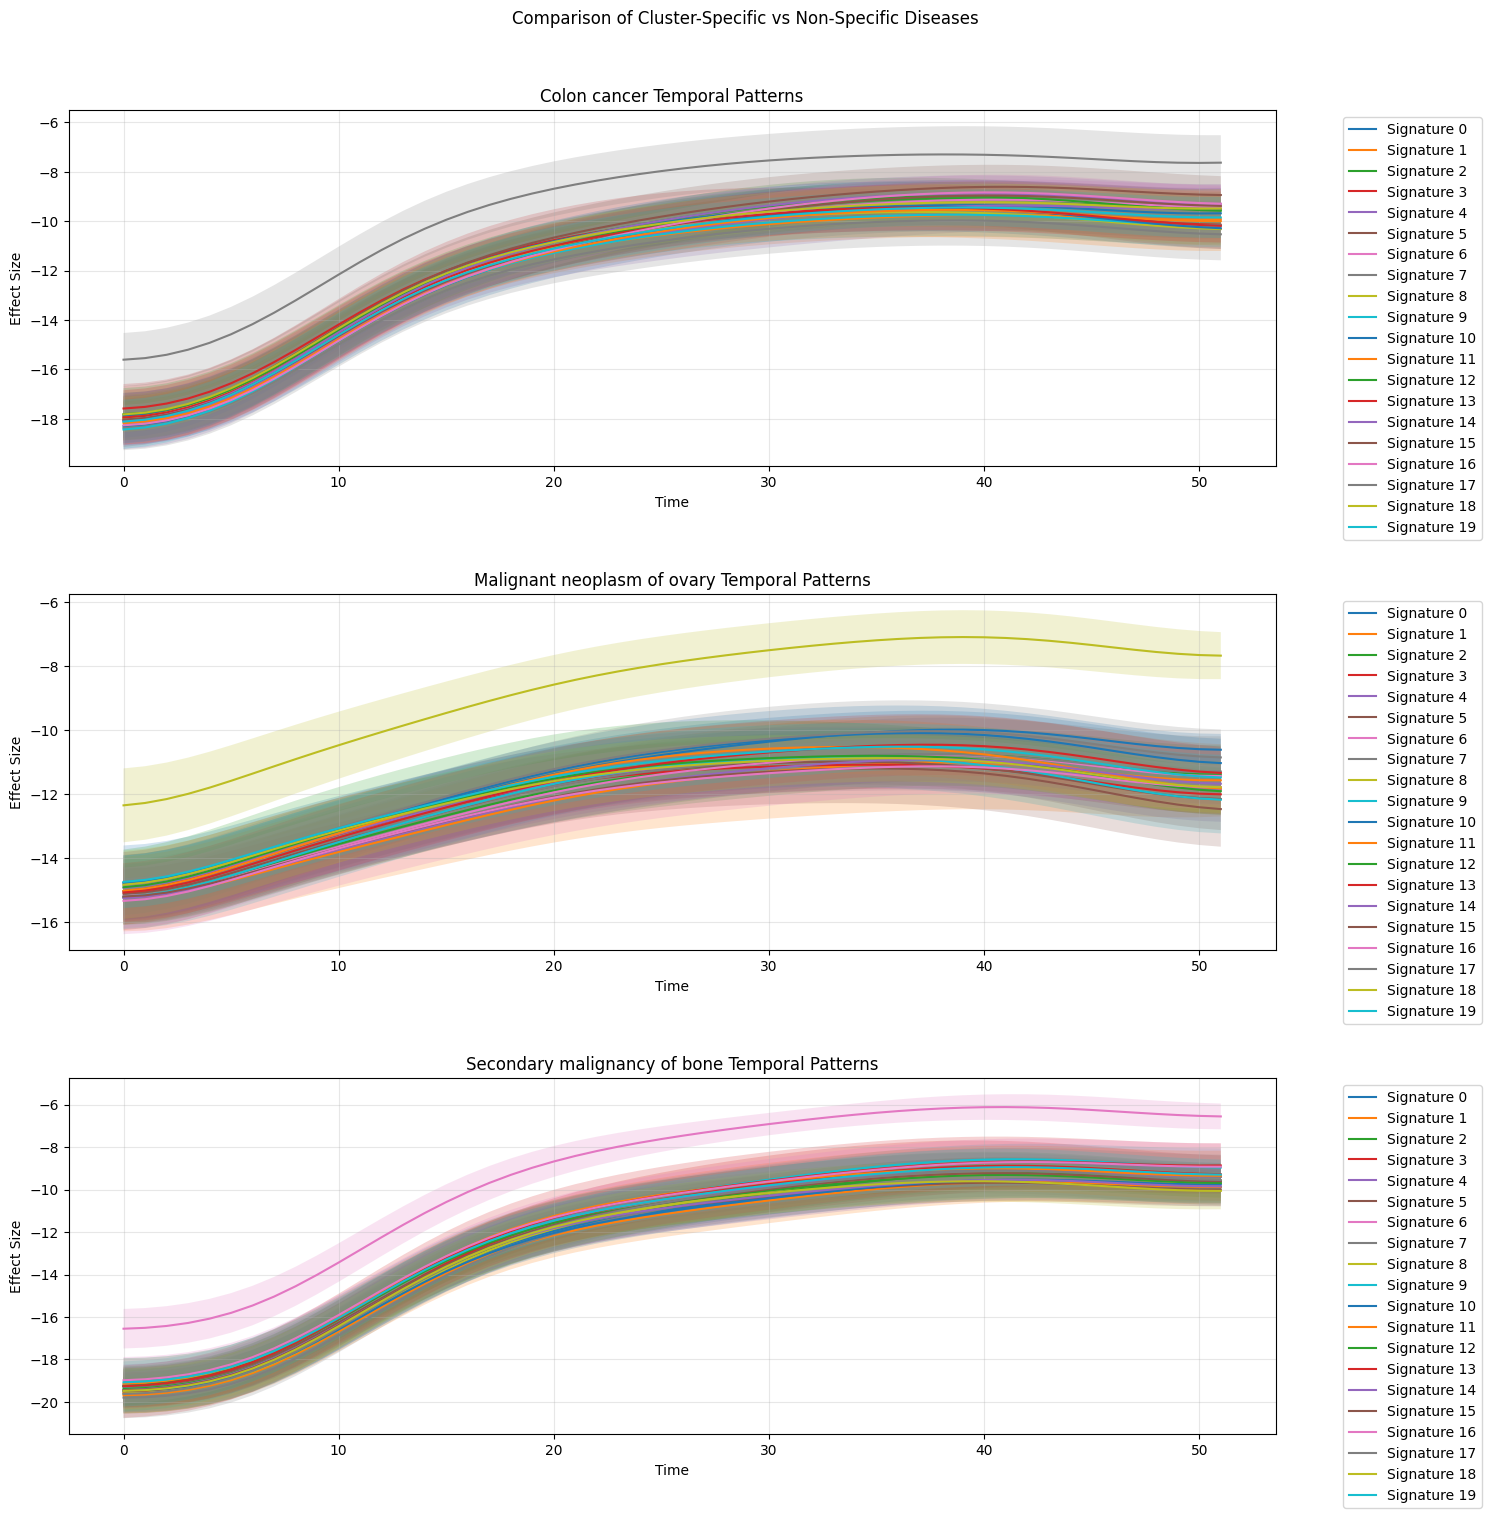

In [70]:
import torch
import numpy as np
import os
import glob

def analyze_pooled_cluster_patterns(base_dir):
    """
    Analyze patterns pooling across all model.pt files in subdirectories
    """
    # Get all output directories
    output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')))
    
    # Initialize storage for pooled phi values
    first_model = torch.load(os.path.join(output_dirs[0], 'model.pt'))
    disease_names = first_model['disease_names']
    phi_shape = first_model['model_state_dict']['phi'].shape
    pooled_phi = np.zeros((len(output_dirs), *phi_shape))
    
    # Load and pool phi values
    for i, dir_path in enumerate(output_dirs):
        model_path = os.path.join(dir_path, 'model.pt')
        try:
            checkpoint = torch.load(model_path)
            phi = checkpoint['model_state_dict']['phi']
            if torch.is_tensor(phi):
                phi = phi.detach().cpu().numpy()
            pooled_phi[i] = phi
            
            # Use clusters from first model (assuming consistent across runs)
            if i == 0:
                clusters = checkpoint['clusters']
                
        except Exception as e:
            print(f"Error loading from {dir_path}: {e}")
    
    # Calculate mean and std of phi across all models
    mean_phi = np.mean(pooled_phi, axis=0)
    std_phi = np.std(pooled_phi, axis=0)
    
    # Analyze patterns for each cluster
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        cluster_diseases = np.where(clusters == cluster)[0]
        
        print(f"\nCluster {cluster} diseases:")
        print("------------------------")
        
        # Get average phi values for diseases in this cluster
        cluster_phi = mean_phi[:, cluster_diseases, :].mean(axis=2)  # Average over time
        cluster_phi_std = std_phi[:, cluster_diseases, :].mean(axis=2)  # Average std over time
        
        # Find dominant signature
        dominant_signature = np.argmax(np.abs(cluster_phi).mean(axis=1))
        
        # Sort diseases by their strength in the dominant signature
        disease_strengths = mean_phi[dominant_signature, cluster_diseases, :].mean(axis=1)
        disease_stds = std_phi[dominant_signature, cluster_diseases, :].mean(axis=1)
        sorted_indices = np.argsort(np.abs(disease_strengths))[::-1]
        
        # Print top 5 most characteristic diseases
        print(f"Top diseases (strongest in signature {dominant_signature}):")
        for idx in sorted_indices[:5]:
            disease_idx = cluster_diseases[idx]
            strength = disease_strengths[idx]
            std = disease_stds[idx]
            print(f"- {disease_names[disease_idx]}: strength = {strength:.3f} ± {std:.3f}")
        
        # Find non-specific diseases
        other_sigs = np.delete(np.arange(mean_phi.shape[0]), dominant_signature)
        non_specific_diseases = []
        
        for disease_idx in cluster_diseases:
            disease_phi = mean_phi[:, disease_idx, :].mean(axis=1)
            if np.any(np.abs(disease_phi[other_sigs]) > 0.5 * np.abs(disease_phi[dominant_signature])):
                non_specific_diseases.append(disease_idx)
        
        if non_specific_diseases:
            print("\nNon-specific diseases (strong effects in multiple signatures):")
            for disease_idx in non_specific_diseases[:5]:
                disease_phi = mean_phi[:, disease_idx, :].mean(axis=1)
                disease_phi_std = std_phi[:, disease_idx, :].mean(axis=1)
                print(f"\n{disease_names[disease_idx]}:")
                for sig in range(len(disease_phi)):
                    if abs(disease_phi[sig]) > 0.1:
                        print(f"  Signature {sig}: {disease_phi[sig]:.3f} ± {disease_phi_std[sig]:.3f}")
    
    return pooled_phi, disease_names, clusters

def plot_pooled_disease_patterns(pooled_phi, disease_names, disease_indices, title=None):
    """
    Plot temporal patterns with uncertainty bands for specific diseases
    """
    mean_phi = np.mean(pooled_phi, axis=0)
    std_phi = np.std(pooled_phi, axis=0)
    
    n_signatures = mean_phi.shape[0]
    n_timepoints = mean_phi.shape[2]
    
    plt.figure(figsize=(15, 5 * len(disease_indices)))
    
    for i, disease_idx in enumerate(disease_indices):
        plt.subplot(len(disease_indices), 1, i+1)
        
        for sig in range(n_signatures):
            mean_pattern = mean_phi[sig, disease_idx, :]
            std_pattern = std_phi[sig, disease_idx, :]
            
            plt.plot(range(n_timepoints), mean_pattern, label=f'Signature {sig}')
            plt.fill_between(range(n_timepoints), 
                           mean_pattern - std_pattern,
                           mean_pattern + std_pattern,
                           alpha=0.2)
        
        plt.title(f"{disease_names[disease_idx]} Temporal Patterns")
        plt.xlabel('Time')
        plt.ylabel('Effect Size')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    
    if title:
        plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# Usage:
base_dir = '/Users/sarahurbut/Dropbox (Personal)/results_10k_unsharedseed/'
pooled_phi, disease_names, clusters = analyze_pooled_cluster_patterns(base_dir)

# After identifying interesting diseases from the analysis:
interesting_diseases = [10, 20, 30]  # Replace with actual disease indices
plot_pooled_disease_patterns(pooled_phi, disease_names, interesting_diseases,
                           title="Comparison of Cluster-Specific vs Non-Specific Diseases")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/3328720815.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_di


Disease: Colon cancer
Assigned signature (positive psi): 17


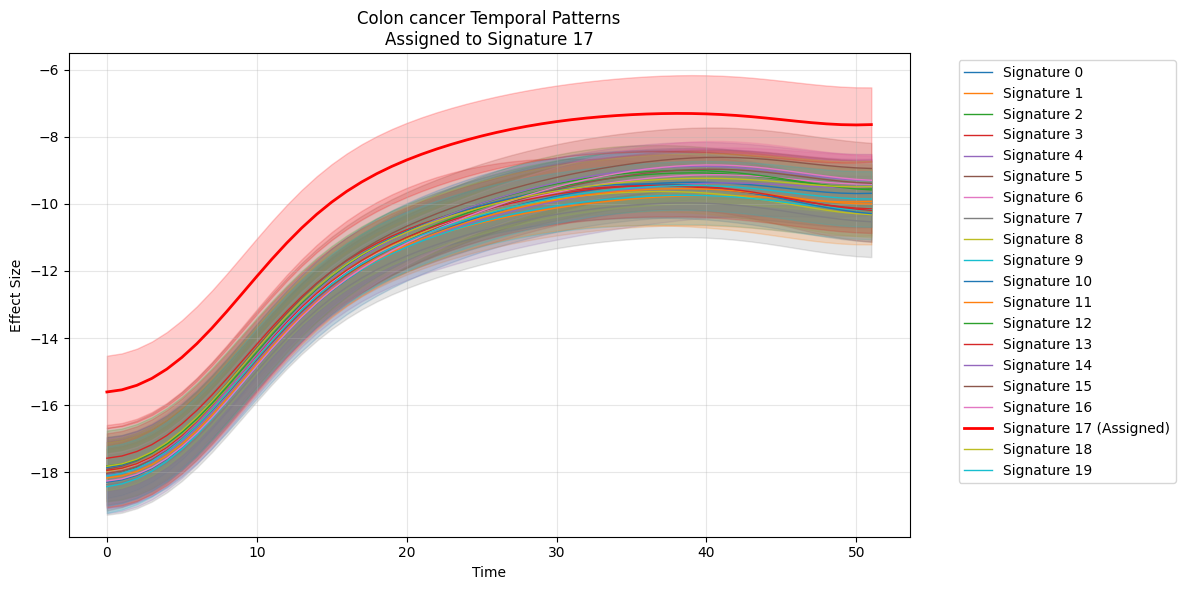


Average effect sizes across signatures:
Signature 0: -11.836 ± 0.998
Signature 1: -11.932 ± 0.896
Signature 2: -11.600 ± 0.833
Signature 3: -11.601 ± 0.983
Signature 4: -11.800 ± 1.042
Signature 5: -11.226 ± 0.995
Signature 6: -11.603 ± 0.907
Signature 7: -12.255 ± 0.977
Signature 8: -11.841 ± 0.732
Signature 9: -12.044 ± 0.786
Signature 10: -11.665 ± 0.888
Signature 11: -11.905 ± 0.963
Signature 12: -11.471 ± 0.790
Signature 13: -11.757 ± 0.936
Signature 14: -11.446 ± 0.806
Signature 15: -11.586 ± 0.745
Signature 16: -11.608 ± 0.709
Signature 17: -9.470 ± 1.116 *
Signature 18: -11.534 ± 0.748
Signature 19: -11.790 ± 0.826


In [79]:

def verify_disease_signature_specificity(base_dir, disease_idx):
    """
    Verify that the dominant signature matches the cluster assignment for a disease
    """
    # Load first model to get psi and cluster assignments
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000_20241223_041640/model.pt'))
    psi = first_model['model_state_dict']['psi']
    disease_names = first_model['disease_names']
    
    if torch.is_tensor(psi):
        psi = psi.detach().cpu().numpy()
    
    # Find which signature has positive psi for this disease
    assigned_signature = np.where(psi[:, disease_idx] > 0)[0]
    print(f"\nDisease: {disease_names[disease_idx]}")
    print(f"Assigned signature (positive psi): {assigned_signature[0]}")
    
    # Now load and pool phi values across all models
    output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')))
    phi_shape = first_model['model_state_dict']['phi'].shape
    pooled_phi = np.zeros((len(output_dirs), *phi_shape))
    
    for i, dir_path in enumerate(output_dirs):
        model_path = os.path.join(dir_path, 'model.pt')
        try:
            checkpoint = torch.load(model_path)
            phi = checkpoint['model_state_dict']['phi']
            if torch.is_tensor(phi):
                phi = phi.detach().cpu().numpy()
            pooled_phi[i] = phi
        except Exception as e:
            print(f"Error loading from {dir_path}: {e}")
    
    # Calculate mean phi
    mean_phi = np.mean(pooled_phi, axis=0)
    std_phi = np.std(pooled_phi, axis=0)
    
    # Plot temporal patterns with assigned signature highlighted
    plt.figure(figsize=(12, 6))
    
    for sig in range(mean_phi.shape[0]):
        mean_pattern = mean_phi[sig, disease_idx, :]
        std_pattern = std_phi[sig, disease_idx, :]
        
        # Highlight assigned signature
        if sig == assigned_signature:
            color = 'red'
            linewidth = 2
            label = f'Signature {sig} (Assigned)'
        else:
            color = f'C{sig}'
            linewidth = 1
            label = f'Signature {sig}'
        
        plt.plot(range(mean_pattern.shape[0]), mean_pattern, 
                label=label, color=color, linewidth=linewidth)
        plt.fill_between(range(mean_pattern.shape[0]), 
                        mean_pattern - std_pattern,
                        mean_pattern + std_pattern,
                        color=color, alpha=0.2)
    
    plt.title(f"{disease_names[disease_idx]} Temporal Patterns\nAssigned to Signature {assigned_signature[0]}")
    plt.xlabel('Time')
    plt.ylabel('Effect Size')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print effect sizes
    mean_effects = mean_phi[:, disease_idx, :].mean(axis=1)
    std_effects = std_phi[:, disease_idx, :].mean(axis=1)
    
    print("\nAverage effect sizes across signatures:")
    for sig in range(len(mean_effects)):
        star = " *" if sig == assigned_signature else ""
        print(f"Signature {sig}: {mean_effects[sig]:.3f} ± {std_effects[sig]:.3f}{star}")

# Usage:
base_dir = '/Users/sarahurbut/Dropbox (Personal)/results_10k_unsharedseed/'
disease_idx = 10  # Replace with the disease index you want to check
verify_disease_signature_specificity(base_dir, disease_idx)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/3328720815.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_di


Disease: Bacterial infection NOS
Assigned signature (positive psi): 16


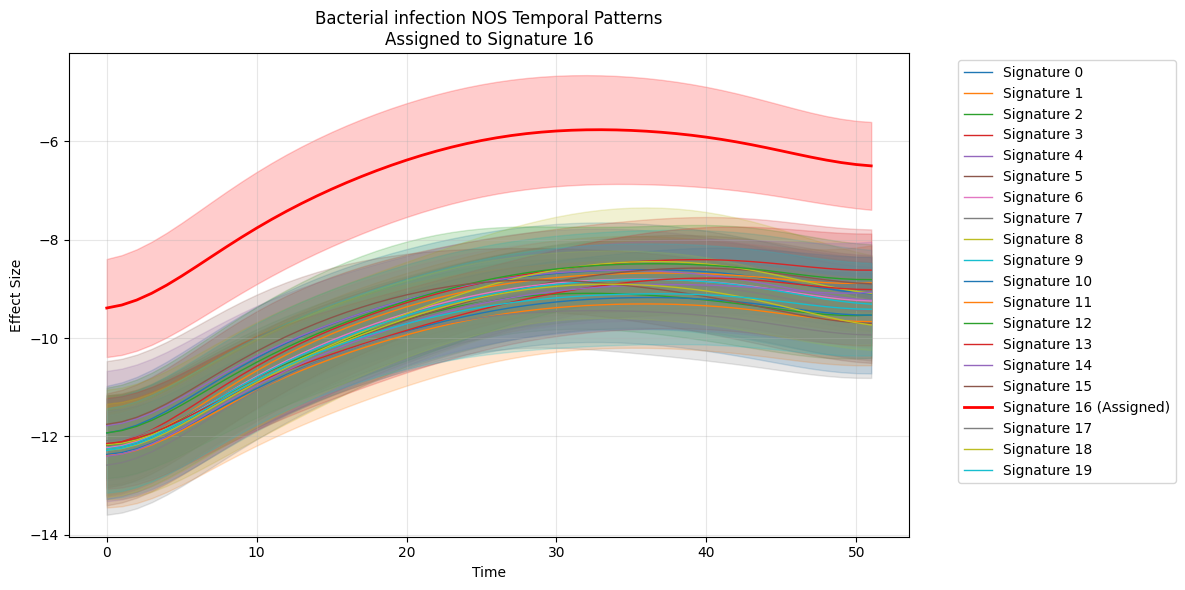


Average effect sizes across signatures:
Signature 0: -9.492 ± 0.946
Signature 1: -9.610 ± 0.722
Signature 2: -9.932 ± 0.824
Signature 3: -9.445 ± 0.948
Signature 4: -9.496 ± 0.884
Signature 5: -9.696 ± 0.819
Signature 6: -9.748 ± 0.930
Signature 7: -9.843 ± 0.944
Signature 8: -9.616 ± 1.069
Signature 9: -9.774 ± 1.052
Signature 10: -10.063 ± 0.913
Signature 11: -10.153 ± 0.987
Signature 12: -9.442 ± 0.967
Signature 13: -9.832 ± 0.957
Signature 14: -9.875 ± 0.906
Signature 15: -9.632 ± 0.884
Signature 16: -6.758 ± 1.074 *
Signature 17: -10.247 ± 0.873
Signature 18: -9.902 ± 0.758
Signature 19: -9.945 ± 0.951


In [80]:
verify_disease_signature_specificity(base_dir, 3)

['/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_0_10000_20241225_062028',
 '/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_100000_110000_20241225_225116',
 '/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_10000_20000_20241225_062028',
 '/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_110000_120000_20241225_225127',
 '/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_120000_130000_20241226_020120',
 '/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_130000_140000_20241226_020134',
 '/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_140000_150000_20241226_051212',
 '/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_150000_160000_20241226_051223',
 '/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_160000_170000_20241226_082535',
 '/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_170000_180000_20241226_082558',
 '/Users/sarahurbut/Dropbox 

NOw do all with same seed


In [1]:
import torch
import numpy as np
import os
import glob

# Base directory containing all output folders
base_dir = '/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/'

# List all output directories
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')))

# Initialize list to store all phis
all_phis = []

# Load phi from each model
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        # Load the saved model
        checkpoint = torch.load(model_path)
        
        # Extract phi - might need to adjust based on how it's stored
        if 'model_state_dict' in checkpoint:
            # If phi is in state dict
            phi = checkpoint['model_state_dict']['phi']
        else:
            # If phi is stored directly
            phi = checkpoint['phi']
            
        # Convert to numpy if it's a tensor
        if torch.is_tensor(phi):
            phi = phi.detach().cpu().numpy()
            
        all_phis.append(phi)
        print(f"Loaded phi from {dir_path}")
        
    except Exception as e:
        print(f"Error loading from {dir_path}: {e}")

# Convert list to numpy array
all_phis = np.array(all_phis)


In [56]:
all_phis[3,5,7,:]

array([-14.4437685, -14.447313 , -14.424282 , -14.378359 , -14.314302 ,
       -14.237385 , -14.152662 , -14.064531 , -13.976446 , -13.890878 ,
       -13.809409 , -13.732987 , -13.662123 , -13.597082 , -13.537991 ,
       -13.484928 , -13.437833 , -13.396535 , -13.360718 , -13.329936 ,
       -13.303594 , -13.281114 , -13.2618885, -13.245349 , -13.231022 ,
       -13.218549 , -13.207606 , -13.197881 , -13.189055 , -13.18072  ,
       -13.172402 , -13.16368  , -13.154117 , -13.143393 , -13.13146  ,
       -13.1185   , -13.104954 , -13.0915   , -13.078987 , -13.0683155,
       -13.060321 , -13.055646 , -13.05455  , -13.056743 , -13.061204 ,
       -13.06601  , -13.068282 , -13.064287 , -13.049746 , -13.020224 ,
       -12.971797 , -12.9016905], dtype=float32)

In [58]:
all_phis.shape


(40, 20, 348, 52)

In [5]:
base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/'

# List all output directories
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')))
output_dirs


['/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028',
 '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_100000_110000_20241225_225116',
 '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_10000_20000_20241225_062028',
 '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_110000_120000_20241225_225127',
 '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_120000_130000_20241226_020120',
 '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_130000_140000_20241226_020134',
 '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_140000_150000_20241226_051212',
 '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_150000_160000_20241226_051223',
 '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_160000_170000_20241226_082535',
 '/Users/sarahurbut/Dropbox (Personal)/from_A

In [6]:

# Initialize list to store all phis
all_phis = []
dir_path=output_dirs[0]
model_path = os.path.join(dir_path, 'model.pt')
checkpoint = torch.load(model_path)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_6481/1906698428.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [22]:
gamma = checkpoint['model_state_dict']['gamma']
gamma.shape


torch.Size([36, 20])

In [23]:
type(gamma)

torch.Tensor

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
import numpy as np

# Read the RDS file using rpy2
prs_names = np.array(robjects.r.readRDS('/Users/sarahurbut/Dropbox (Personal)/prs_names.rds'))
prs_names


array(['AAM', 'AMD', 'AD', 'AST', 'AF', 'BD', 'BMI', 'CRC', 'BC', 'CVD',
       'CED', 'CAD', 'CD', 'EOC', 'EBMDT', 'HBA1C_DF', 'HEIGHT', 'HDL',
       'HT', 'IOP', 'ISS', 'LDL_SF', 'MEL', 'MS', 'OP', 'PD', 'POAG',
       'PC', 'PSO', 'RA', 'SCZ', 'SLE', 'T1D', 'T2D', 'UC', 'VTE'],
      dtype='<U8')

In [34]:
gamma.shape

torch.Size([36, 20])

In [37]:
gamma_np.shape
gamma_df.shape

(20, 36)

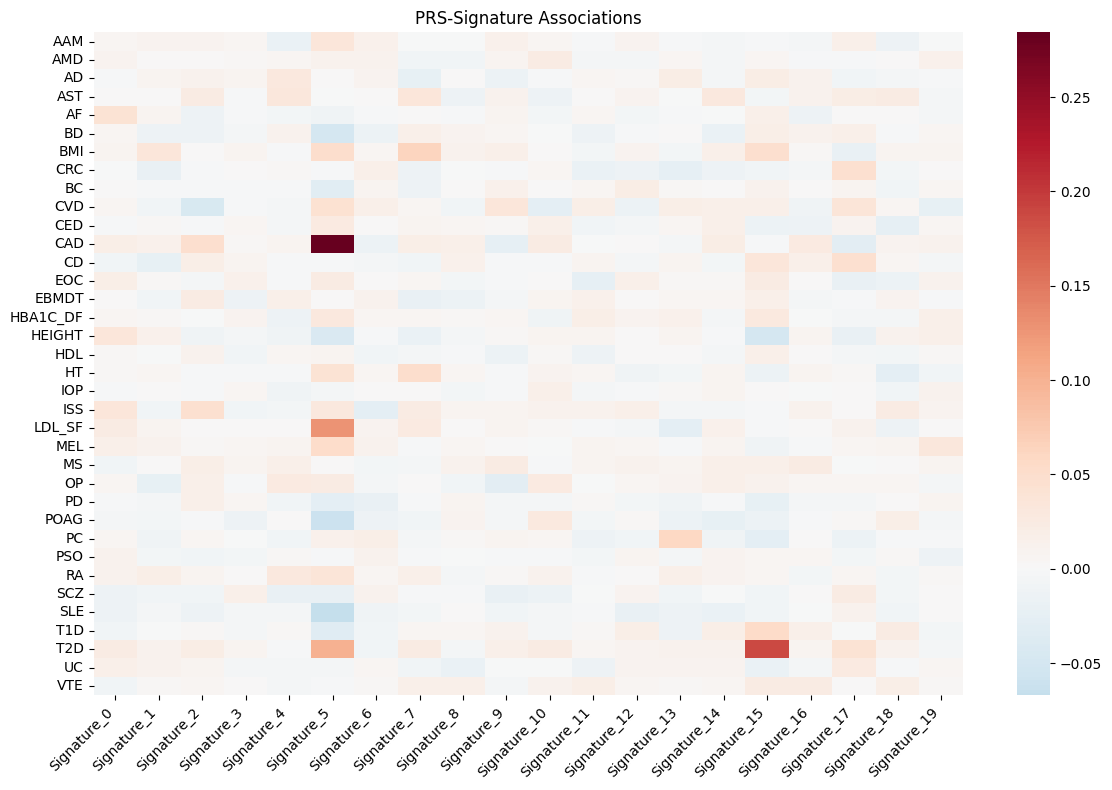

In [39]:
# Create signature names (20 signatures)
sig_names = [f'Signature_{i}' for i in range(20)]

# Create the DataFrame with correct dimensions
gamma_df = pd.DataFrame(gamma_np)  # Transpose to get PRS traits as rows (36) and signatures as columns (20)

# Set the labels
gamma_df.columns = sig_names  # 20 signature names for columns
gamma_df.index = prs_names    # 36 PRS names for rows

# Create heatmap with rotated labels
plt.figure(figsize=(12, 8))
sns.heatmap(gamma_df, 
            cmap='RdBu_r',
            center=0,
            xticklabels=True,
            yticklabels=True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('PRS-Signature Associations')
plt.tight_layout()
plt.show()

In [46]:
all_phis[3,1,1,:]

array([-15.503987 , -15.431744 , -15.304807 , -15.132924 , -14.928651 ,
       -14.705385 , -14.475567 , -14.249226 , -14.033224 , -13.831159 ,
       -13.643805 , -13.469866 , -13.306853 , -13.151834 , -13.002043 ,
       -12.85515  , -12.709556 , -12.564185 , -12.418597 , -12.272718 ,
       -12.126815 , -11.981623 , -11.838055 , -11.697049 , -11.559786 ,
       -11.427589 , -11.301643 , -11.183104 , -11.072846 , -10.971567 ,
       -10.879671 , -10.797351 , -10.724629 , -10.661487 , -10.608015 ,
       -10.564512 , -10.531619 , -10.510289 , -10.501758 , -10.507432 ,
       -10.528638 , -10.566407 , -10.621158 , -10.69248  , -10.778897 ,
       -10.877775 , -10.985331 , -11.0967865, -11.206731 , -11.30963  ,
       -11.400389 , -11.474953 ], dtype=float32)

In [47]:
# Calculate statistics
mean_phi = np.mean(all_phis, axis=0)
std_phi = np.std(all_phis, axis=0)
ci_phi = 1.96 * std_phi / np.sqrt(len(all_phis))  # 95% CI

# Save results
np.save('mean_phi_same.npy', mean_phi)
np.save('std_phi_same.npy', std_phi)
np.save('ci_phi_same.npy', ci_phi)


In [48]:

# Select some interesting diseases and signatures to plot
diseases_to_plot = [0, 1, 2]  # replace with actual disease indices of interest
signatures_to_plot = [0, 1, 2]  # replace with signatures of interest

# Create plots
for k in signatures_to_plot:
    for d in diseases_to_plot:
        plt.figure(figsize=(12, 6))
        
        # Plot individual batch trajectories in light gray
        for batch_phi in all_phis:
            plt.plot(batch_phi[k, d, :], color='gray', alpha=0.2)
        
        # Plot mean trajectory in bold
        plt.plot(mean_phi[k, d, :], color='blue', linewidth=2, label='Mean')
        
        # Add confidence intervals
        std_phi = np.std(all_phis[:, k, d, :], axis=0)
        ci = 1.96 * std_phi / np.sqrt(len(all_phis))
        plt.fill_between(range(mean_phi.shape[2]), 
                        mean_phi[k, d, :] - ci,
                        mean_phi[k, d, :] + ci,
                        alpha=0.2, color='blue')
        
        plt.title(f'Signature {k}, Disease {d} Temporal Pattern')
        plt.xlabel('Time')
        plt.ylabel('Phi Value')
        plt.grid(True, alpha=0.3)
        plt.savefig(f'phi_trajectory_sig{k}_disease{d}_sameseed.png')
        plt.close()

In [123]:
import torch
import numpy as np
import os
import glob

# Base directory containing all output folders
base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/'

# List all output directories
# List all output directories
dir_path = sorted(glob.glob(os.path.join(base_dir, 'output_10000_20000_20241225_062028')))



In [125]:
dir_path

['/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_10000_20000_20241225_062028']

In [40]:


model_path = os.path.join(dir_path, 'model.pt')
checkpoint = torch.load(model_path)
ytest=checkpoint['Y']
indes=checkpoint['indices']

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_6481/1505807544.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [109]:
Yt=torch.load("/Users/sarahurbut/Dropbox (Personal)/filesforupload/Y_tensor.pt")
E=torch.load("/Users/sarahurbut/Dropbox (Personal)/filesforupload/E_matrix.pt")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/1397768674.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Yt=torch.load("/Users/sarahurbut/Dropbox (Per

In [116]:
# Python
# Assuming E is a numpy array
indices = np.where(E[10000,:] != 51)[0]
values = E[10000,indices]
print("Positions:", indices)
print("Values:", values)

# To see position-value pairs:
for pos, val in zip(indices, values):
    print(f"Position {pos}: {val}")

    

Positions: [ 90 109 180 230 299 344 347]
Values: tensor([42, 42, 38, 42, 35, 35, 42])
Position 90: 42
Position 109: 42
Position 180: 38
Position 230: 42
Position 299: 35
Position 344: 35
Position 347: 42


In [118]:
Yt[10000,90,42]

tensor(1.)

In [128]:
import rpy2.robjects as robjects
import numpy as np

# Load the original sparse array from R
r_sparse = robjects.r.readRDS('/Users/sarahurbut/Dropbox (Personal)/withsparse/sparse_array.rds')
matrix = r_sparse[0]  # Get first timepoint

# Try to get rownames using R functions directly
try:
    # Convert to R matrix first
    robjects.r('''
        get_rownames <- function(sparse_matrix) {
            rownames(sparse_matrix)
        }
    ''')
    get_rownames = robjects.globalenv['get_rownames']
    all_patient_ids = np.array(get_rownames(matrix))
    print(f"Successfully extracted {len(all_patient_ids)} patient IDs")
except Exception as e:
    print(f"Error with R method: {e}")
    try:
        # Alternative: try getting directly from matrix slots
        all_patient_ids = np.array(matrix.slots['Dimnames'][0])
        print(f"Got IDs from slots: {len(all_patient_ids)} IDs")
    except Exception as e2:
        print(f"Error with slots method: {e2}")

# Verify we have the IDs
if 'all_patient_ids' in locals():
    print("First few IDs:", all_patient_ids[:5])
    
    def get_batch_ids(start_idx, end_idx):
        return all_patient_ids[start_idx:end_idx]

    # Example: get IDs for first batch
    batch_0_10k_ids = get_batch_ids(0, 10000)
    print(f"First batch IDs: {batch_0_10k_ids[:5]}...")
else:
    print("Failed to get patient IDs")



Successfully extracted 407878 patient IDs
First few IDs: ['1000015' '1000023' '1000037' '1000042' '1000059']
First batch IDs: ['1000015' '1000023' '1000037' '1000042' '1000059']...


In [129]:
import numpy as np

# Convert to numpy array if not already
patient_ids = np.array(all_patient_ids)

# Save to file
np.save('patient_ids.npy', patient_ids)

In [145]:
import os
import glob
import numpy as np
import torch
import re

# Base directory containing all output folders
base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/'

# List all output directories and sort them properly by their index numbers
def sort_by_index(dir_name):
    # Extract just the start number from directory name
    # e.g., from 'output_10000_20000_20241225_062028' get '10000'
    match = re.search(r'output_(\d+)_\d+_\d+', dir_name)
    if match:
        return int(match.group(1))
    return 0

# Test the sorting
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')), key=sort_by_index)

# Print first few directories to verify sorting
print("Verifying directory sorting:")
for dir_path in output_dirs[:5]:
    print(dir_path)


# Initialize the full array
all_lambdas = np.zeros((400000, 20, 52))  # [n_individuals, n_signatures, n_timepoints]

# Keep track of processed indices
processed_ranges = []

# Load and combine lambda from each model
current_idx = 0
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        # Extract batch range from directory name
        batch_range = re.findall(r'output_(\d+)_(\d+)', os.path.basename(dir_path))
        if batch_range:
            start_idx, end_idx = map(int, batch_range[0])
            print(f"\nProcessing batch {start_idx}-{end_idx}")
            
            # Verify this matches our current_idx
            if current_idx != start_idx:
                print(f"WARNING: Index mismatch! current_idx={current_idx}, but batch starts at {start_idx}")
        
        # Load the saved model
        checkpoint = torch.load(model_path)
        
        # Extract lambda
        if 'model_state_dict' in checkpoint:
            lambda_values = checkpoint['model_state_dict']['lambda_']
        else:
            lambda_values = checkpoint['lambda_']
            
        # Convert to numpy if it's a tensor
        if torch.is_tensor(lambda_values):
            lambda_values = lambda_values.detach().cpu().numpy()
        
        # Get batch size
        batch_size = lambda_values.shape[0]
        
        # Add to the full array
        all_lambdas[current_idx:current_idx + batch_size] = lambda_values
        
        # Store processed range
        processed_ranges.append((current_idx, current_idx + batch_size))
        
        print(f"Loaded lambda from {dir_path}")
        print(f"Batch size: {batch_size}")
        print(f"Current index range: {current_idx} to {current_idx + batch_size}")
        
        current_idx += batch_size
        
    except Exception as e:
        print(f"Error loading from {dir_path}: {e}")

# Verify no gaps or overlaps in processed ranges
processed_ranges.sort()
for i in range(len(processed_ranges)-1):
    if processed_ranges[i][1] != processed_ranges[i+1][0]:
        print(f"WARNING: Gap or overlap between batches! {processed_ranges[i]} and {processed_ranges[i+1]}")

# Save the combined lambdas
np.save('all_lambdas_combined.npy', all_lambdas)

# Print final verification
print("\nFinal verification:")
print("Shape of all_lambdas:", all_lambdas.shape)
print("Total individuals processed:", current_idx)
print("Processed ranges:", processed_ranges)

# Load patient IDs and verify length matches
patient_ids = np.load('/Users/sarahurbut/Dropbox (Personal)/patient_ids.npy')
# Verify dimensions
print("Total available patient IDs:", len(patient_ids))  # Should be 407,878
print("Processed lambda shape:", all_lambdas.shape)      # Should be (400000, 20, 52)

# Create mapping of processed IDs
processed_ids = patient_ids[:400000]  # Get just the first 400K IDs we processed
print("\nVerification of processed IDs:")
print("Number of processed IDs:", len(processed_ids))
print("First few IDs:", processed_ids[:5])
print("Last few IDs:", processed_ids[-5:])

# Save the processed IDs mapping
np.save('processed_patient_ids.npy', processed_ids)

# Print some stats about unprocessed patients
unprocessed_ids = patient_ids[400000:]
print("\nUnprocessed patients:")
print("Number of unprocessed IDs:", len(unprocessed_ids))
print("First few unprocessed IDs:", unprocessed_ids[:5])

Verifying directory sorting:
/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028
/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_10000_20000_20241225_062028
/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_20000_30000_20241225_093441
/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_30000_40000_20241225_093452
/Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_40000_50000_20241225_124544

Processing batch 0-10000


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/1239961796.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028
Batch size: 10000
Current index range: 0 to 10000

Processing batch 10000-20000
Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_10000_20000_20241225_062028
Batch size: 10000
Current index range: 10000 to 20000

Processing batch 20000-30000
Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_20000_30000_20241225_093441
Batch size: 10000
Current index range: 20000 to 30000

Processing batch 30000-40000
Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_30000_40000_20241225_093452
Batch size: 10000
Current index range: 30000 to 40000

Processing batch 40000-50000
Loaded lambda from /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_40000_50000_20241225_124544
Batch size: 10000
Current index range: 40000 to 50000

Processing batch 

In [41]:
import os
import glob
import numpy as np
import torch
from scipy.special import softmax, expit

def calculate_conditional_probs(lambda_values, phi_values, Y_data, cad_idx, time_x, target_disease_idx):
    """
    Calculate conditional probabilities for a batch of individuals
    """
    # Get CAD status before time_x
    cad_before_x = np.any(Y_data[:, cad_idx, :time_x], axis=1)
    
    # Calculate thetas
    thetas = softmax(lambda_values, axis=1)
    
    # Calculate pi for target disease
    pi = np.zeros((lambda_values.shape[0], lambda_values.shape[2]))
    for t in range(lambda_values.shape[2]):
        for k in range(lambda_values.shape[1]):
            pi[:, t] += thetas[:, k, t] * expit(phi_values[k, target_disease_idx, t])
    
    return pi, cad_before_x

# Initialize storage for results
all_conditional_probs = []
all_cad_statuses = []

# Process each batch
for dir_path in output_dirs:
    model_path = os.path.join(dir_path, 'model.pt')
    try:
        # Load the saved model
        checkpoint = torch.load(model_path)
        
        # Extract necessary components
        if 'model_state_dict' in checkpoint:
            lambda_values = checkpoint['model_state_dict']['lambda_']
            phi_values = checkpoint['model_state_dict']['phi']
        else:
            lambda_values = checkpoint['lambda_']
            phi_values = checkpoint['phi']
            
        # Convert to numpy if needed
        if torch.is_tensor(lambda_values):
            lambda_values = lambda_values.detach().cpu().numpy()
        if torch.is_tensor(phi_values):
            phi_values = phi_values.detach().cpu().numpy()
            
        # Get Y data for this batch
        Y_batch = checkpoint['Y']
        if torch.is_tensor(Y_batch):
            Y_batch = Y_batch.detach().cpu().numpy()
            
        # Get disease indices
        disease_names = checkpoint['disease_names']
        cad_idx = disease_names.index('CAD')  # adjust if CAD is named differently
        target_disease_idx = disease_names.index('TARGET_DISEASE')  # replace with your target disease
        
        # Calculate conditional probabilities for this batch
        time_x = 26  # halfway point, adjust as needed
        pi_batch, cad_status = calculate_conditional_probs(
            lambda_values,
            phi_values,
            Y_batch,
            cad_idx,
            time_x,
            target_disease_idx
        )
        
        # Store results
        all_conditional_probs.append(pi_batch)
        all_cad_statuses.append(cad_status)
        
    except Exception as e:
        print(f"Error processing {dir_path}: {e}")

# Combine results
all_conditional_probs = np.concatenate(all_conditional_probs, axis=0)
all_cad_statuses = np.concatenate(all_cad_statuses, axis=0)

# Calculate statistics for those with CAD before time_x
conditional_probs_given_cad = all_conditional_probs[all_cad_statuses]
mean_trajectory = np.mean(conditional_probs_given_cad, axis=0)
ci_lower = np.percentile(conditional_probs_given_cad, 2.5, axis=0)
ci_upper = np.percentile(conditional_probs_given_cad, 97.5, axis=0)

# Save results
np.save('conditional_probs.npy', conditional_probs_given_cad)
np.save('mean_trajectory.npy', mean_trajectory)
np.save('ci_bounds.npy', np.array([ci_lower, ci_upper]))

# Print summary statistics
print(f"Total individuals: {len(all_cad_statuses)}")
print(f"Individuals with early CAD: {np.sum(all_cad_statuses)}")
print(f"Proportion with early CAD: {np.mean(all_cad_statuses):.3f}")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_6481/4171784616.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Error processing /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_0_10000_20241225_062028: 'CAD' is not in list
Error processing /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_100000_110000_20241225_225116: 'CAD' is not in list
Error processing /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_10000_20000_20241225_062028: 'CAD' is not in list
Error processing /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_110000_120000_20241225_225127: 'CAD' is not in list
Error processing /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_120000_130000_20241226_020120: 'CAD' is not in list
Error processing /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_130000_140000_20241226_020134: 'CAD' is not in list
Error processing /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_140000_150000_20241226_051212: 'CAD' is not in list
Error processi

ValueError: need at least one array to concatenate

In [143]:
bpc = robjects.r.readRDS('/Users/sarahurbut/Downloads/baseline_withPCS.rds')

In [149]:
def softmax(x):
    """
    Compute softmax values for each set of scores in x.
    x shape: (n_individuals, n_signatures, n_timepoints)
    """
    # Reshape to (n_individuals * n_timepoints, n_signatures)
    x_reshaped = x.transpose(0, 2, 1).reshape(-1, x.shape[1])
    
    # Compute softmax
    e_x = np.exp(x_reshaped - np.max(x_reshaped, axis=1, keepdims=True))
    softmax_x = e_x / np.sum(e_x, axis=1, keepdims=True)
    
    # Reshape back to original shape
    return softmax_x.reshape(x.shape[0], x.shape[2], x.shape[1]).transpose(0, 2, 1)

# Calculate thetas using softmax
all_thetas = softmax(all_lambdas)  # shape: (400000, 20, 52)

# Calculate AUC
timepoints = np.arange(52)
theta_aucs = np.array([np.trapz(all_thetas[:, s, :], timepoints) for s in range(20)]).T


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/2601109579.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  theta_aucs = np.array([np.trapz(all_thetas[:, s, :], timepoints) for s in range(20)]).T


In [153]:
def softmax_single(x):
    """
    Compute softmax for a single timepoint
    x shape: (n_signatures,)
    """
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def softmax_full(x):
    """
    Compute softmax for full array
    x shape: (n_individuals, n_signatures, n_timepoints)
    """
    # Reshape to (n_individuals * n_timepoints, n_signatures)
    x_reshaped = x.transpose(0, 2, 1).reshape(-1, x.shape[1])
    
    # Compute softmax
    e_x = np.exp(x_reshaped - np.max(x_reshaped, axis=1, keepdims=True))
    softmax_x = e_x / np.sum(e_x, axis=1, keepdims=True)
    
    # Reshape back
    return softmax_x.reshape(x.shape[0], x.shape[2], x.shape[1]).transpose(0, 2, 1)

# Let's check a few random people at different timepoints
sample_people = [0, 100, 399999]  # First, middle, and last person
sample_timepoints = [0, 25, 51]   # First, middle, and last timepoint

print("Verifying lambda to theta conversion:")
for person in sample_people:
    print(f"\nPerson {person} (ID: {patient_ids[person]}):")
    
    for t in sample_timepoints:
        print(f"\nTimepoint {t}:")
        
        # Get lambdas for this person at this timepoint
        lambdas_t = all_lambdas[person, :, t]
        print("Lambdas:")
        for s in range(20):
            print(f"Signature {s+1}: {lambdas_t[s]:.4f}")
        
        # Calculate thetas using softmax
        thetas_t = softmax_single(lambdas_t)
        print("\nThetas (after softmax):")
        for s in range(20):
            print(f"Signature {s+1}: {thetas_t[s]:.4f}")
            
        # Verify sum to 1
        print(f"\nSum of thetas: {np.sum(thetas_t):.6f}")
        
        # Show top 3 signatures at this timepoint
        top_sigs = np.argsort(thetas_t)[-3:][::-1]
        print("\nTop 3 signatures:")
        for s in top_sigs:
            print(f"Signature {s+1}: {thetas_t[s]:.4f}")

# Calculate full theta array
all_thetas = softmax_full(all_lambdas)

# Verify shapes
print("\nArray shapes:")
print(f"Lambda array shape: {all_lambdas.shape}")
print(f"Theta array shape: {all_thetas.shape}")

Verifying lambda to theta conversion:

Person 0 (ID: 1000015):

Timepoint 0:
Lambdas:
Signature 1: -0.9725
Signature 2: 1.0956
Signature 3: 0.9542
Signature 4: -1.4610
Signature 5: 1.4508
Signature 6: 1.2617
Signature 7: 1.4442
Signature 8: 0.5232
Signature 9: -0.0611
Signature 10: 0.0414
Signature 11: -0.4500
Signature 12: 1.1507
Signature 13: 0.1874
Signature 14: -0.0070
Signature 15: -0.1920
Signature 16: 1.7625
Signature 17: -1.4313
Signature 18: -0.5677
Signature 19: -0.7202
Signature 20: 0.0943

Thetas (after softmax):
Signature 1: 0.0102
Signature 2: 0.0810
Signature 3: 0.0703
Signature 4: 0.0063
Signature 5: 0.1155
Signature 6: 0.0956
Signature 7: 0.1147
Signature 8: 0.0457
Signature 9: 0.0255
Signature 10: 0.0282
Signature 11: 0.0173
Signature 12: 0.0855
Signature 13: 0.0326
Signature 14: 0.0269
Signature 15: 0.0223
Signature 16: 0.1577
Signature 17: 0.0065
Signature 18: 0.0153
Signature 19: 0.0132
Signature 20: 0.0297

Sum of thetas: 1.000000

Top 3 signatures:
Signature 16: 

In [160]:

softmax_single(all_lambdas[1,:,1])

array([0.01075749, 0.04174133, 0.01236625, 0.14625188, 0.13679618,
       0.03809534, 0.02233924, 0.09782585, 0.07387062, 0.01759529,
       0.02754722, 0.01361824, 0.02753008, 0.07331311, 0.01398763,
       0.08847629, 0.0433737 , 0.08821341, 0.00426847, 0.02203236])

In [164]:
all_thetas[0,:,0]

array([0.01023533, 0.08096029, 0.07028231, 0.00627936, 0.11547649,
       0.09558394, 0.1147219 , 0.0456719 , 0.02546299, 0.02821098,
       0.01725846, 0.08554672, 0.03264462, 0.02687726, 0.02233783,
       0.15772179, 0.0064689 , 0.01534278, 0.0131727 , 0.02974346])

In [168]:
person_idx = 0

# Calculate thetas for this person
thetas_person = torch.softmax(torch.tensor(all_lambdas[person_idx]), dim=0).numpy()
thetas_person[:,0]

array([0.01023533, 0.08096029, 0.07028231, 0.00627936, 0.11547649,
       0.09558394, 0.1147219 , 0.0456719 , 0.02546299, 0.02821098,
       0.01725846, 0.08554672, 0.03264462, 0.02687726, 0.02233783,
       0.15772179, 0.0064689 , 0.01534278, 0.0131727 , 0.02974346])


Signature 20 AUC: 3.731
Mean theta: 0.074

Signature 9 AUC: 5.579
Mean theta: 0.108

Signature 6 AUC: 5.350
Mean theta: 0.104


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/3816044577.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(thetas_person[sig], timepoints)


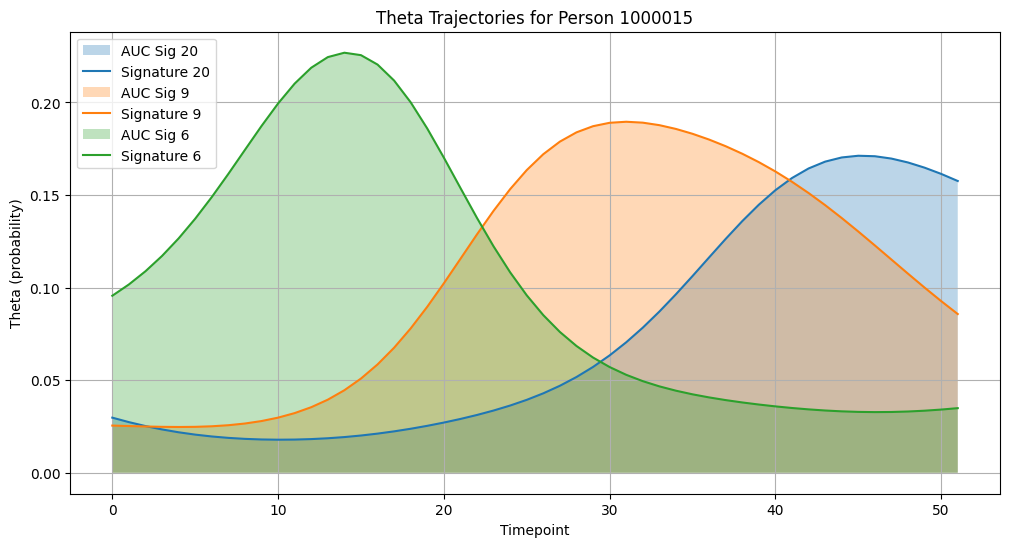

In [162]:
import matplotlib.pyplot as plt

# Take one person as an example
person_idx = 0

# Calculate thetas for this person
thetas_person = torch.softmax(torch.tensor(all_lambdas[person_idx]), dim=0).numpy()

# Plot trajectories for a few signatures
plt.figure(figsize=(12, 6))
timepoints = np.arange(52)

# Plot top 3 signatures by max value
top_sigs = np.argsort(np.max(thetas_person, axis=1))[-3:]

for sig in top_sigs:
    plt.fill_between(timepoints, 0, thetas_person[sig], alpha=0.3, label=f'AUC Sig {sig+1}')
    plt.plot(timepoints, thetas_person[sig], label=f'Signature {sig+1}')

plt.title(f'Theta Trajectories for Person {patient_ids[person_idx]}')
plt.xlabel('Timepoint')
plt.ylabel('Theta (probability)')
plt.legend()
plt.grid(True)

# Calculate and print AUCs for these signatures
for sig in top_sigs:
    auc = np.trapz(thetas_person[sig], timepoints)
    print(f"\nSignature {sig+1} AUC: {auc:.3f}")
    print(f"Mean theta: {np.mean(thetas_person[sig]):.3f}")

In [169]:
import numpy as np
import torch

# Calculate thetas for all individuals
print("Calculating thetas...")
all_thetas = torch.softmax(torch.tensor(all_lambdas), dim=1).numpy()

# Calculate AUC for each person and signature
print("Calculating AUCs...")
timepoints = np.arange(52)
theta_aucs = np.array([np.trapz(all_thetas[:, s, :], timepoints) for s in range(20)]).T

# Create REGENIE phenotype file
output_file = 'signature_auc_phenotypes.txt'
print(f"\nCreating REGENIE phenotype file: {output_file}")

with open(output_file, 'w') as f:
    # Write header
    header = ['FID', 'IID'] + [f'SIG{i+1}_AUC' for i in range(20)]
    f.write('\t'.join(header) + '\n')
    
    # Write data for each person
    for i in range(len(patient_ids)):
        fid = patient_ids[i]
        iid = patient_ids[i]
        aucs = theta_aucs[i]
        
        line = [str(fid), str(iid)] + [f"{x:.6f}" for x in aucs]
        f.write('\t'.join(line) + '\n')

# Print summary statistics
print("\nSummary statistics for signature AUCs:")
for sig in range(20):
    print(f"\nSignature {sig+1}:")
    print(f"Mean: {np.mean(theta_aucs[:, sig]):.4f}")
    print(f"Std: {np.std(theta_aucs[:, sig]):.4f}")
    print(f"Min: {np.min(theta_aucs[:, sig]):.4f}")
    print(f"Max: {np.max(theta_aucs[:, sig]):.4f}")

# Save numpy array version too
np.save('signature_aucs.npy', theta_aucs)

print("\nFiles created:")
print(f"1. {output_file} - REGENIE format")
print("2. signature_aucs.npy - NumPy array")

# Quick verification of a few random individuals
print("\nVerifying random individuals:")
for idx in np.random.choice(len(patient_ids), 3):
    print(f"\nPerson {patient_ids[idx]}:")
    print("AUCs:", theta_aucs[idx])
    print("Sum of AUCs:", np.sum(theta_aucs[idx]))  # Note: won't necessarily sum to 52 (total timepoints)

Calculating thetas...
Calculating AUCs...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/1559298529.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  theta_aucs = np.array([np.trapz(all_thetas[:, s, :], timepoints) for s in range(20)]).T



Creating REGENIE phenotype file: signature_auc_phenotypes.txt

Summary statistics for signature AUCs:

Signature 1:
Mean: 2.5491
Std: 1.9036
Min: 0.1160
Max: 22.8440

Signature 2:
Mean: 2.5505
Std: 1.9289
Min: 0.1067
Max: 18.8861

Signature 3:
Mean: 2.5170
Std: 1.8609
Min: 0.1117
Max: 21.2460

Signature 4:
Mean: 2.5230
Std: 1.9095
Min: 0.1136
Max: 19.1575

Signature 5:
Mean: 2.5408
Std: 1.8979
Min: 0.1226
Max: 17.3734

Signature 6:
Mean: 2.6476
Std: 2.2507
Min: 0.0477
Max: 31.1047

Signature 7:
Mean: 2.5494
Std: 1.9189
Min: 0.0737
Max: 19.3823

Signature 8:
Mean: 2.5566
Std: 1.9146
Min: 0.1088
Max: 20.9530

Signature 9:
Mean: 2.5182
Std: 1.8696
Min: 0.1226
Max: 18.7159

Signature 10:
Mean: 2.5633
Std: 1.9499
Min: 0.1011
Max: 24.3861

Signature 11:
Mean: 2.5566
Std: 1.8972
Min: 0.1055
Max: 19.8881

Signature 12:
Mean: 2.5323
Std: 1.8809
Min: 0.1040
Max: 18.5127

Signature 13:
Mean: 2.5252
Std: 1.9231
Min: 0.0955
Max: 18.7850

Signature 14:
Mean: 2.5493
Std: 1.9483
Min: 0.0753
Max: 24.4

In [ ]:

print("\nSummary statistics for theta AUCs:")
for sig in range(20):
    print(f"\nSignature {sig+1}:")
    print(f"Mean: {np.mean(theta_aucs[:, sig]):.4f}")
    print(f"Std: {np.std(theta_aucs[:, sig]):.4f}")
    print(f"Min: {np.min(theta_aucs[:, sig]):.4f}")
    print(f"Max: {np.max(theta_aucs[:, sig]):.4f}")

# Calculate AUC for each person and signature
for i in range(400000):
    for s in range(20):
        theta_aucs[i, s] = np.trapz(all_thetas[i, s, :], timepoints)

# 2. Load and process covariates from R
# Convert R dataframe to pandas
bpc_pd = pd.DataFrame({
    'identifier': robjects.r.rownames(bpc),
    'sex': np.array(bpc.rx2('f.31.0.0')),
    'birth_year': np.array(bpc.rx2('f.34.0.0')),
    'enrollment': np.array(bpc.rx2('f.53.0.0'))
})

# Add PCs
for i in range(1, 41):  # assuming 40 PCs
    col_name = f'f.22009.0.{i}'
    if col_name in bpc.names:
        bpc_pd[f'PC{i}'] = np.array(bpc.rx2(col_name))

# Create REGENIE phenotype file with patient IDs and theta AUCs
output_file = 'theta_auc_phenotypes_for_regenie.txt'

print("\nPreparing REGENIE phenotype file...")
with open(output_file, 'w') as f:
    # Write header
    header = ['FID', 'IID'] + [f'theta_auc_{i+1}' for i in range(20)]
    f.write('\t'.join(header) + '\n')
    
    # Write data for each person
    for i in range(len(patient_ids)):
        fid = patient_ids[i]
        iid = patient_ids[i]
        
        # Get AUC values for this person
        person_aucs = theta_aucs[i]
        
        # Create line with FID, IID, and AUC values
        line = [str(fid), str(iid)] + [f"{x:.6f}" for x in person_aucs]
        f.write('\t'.join(line) + '\n')

# Print summary statistics
print("\nSummary statistics for theta AUCs:")
for sig in range(20):
    print(f"\nSignature {sig+1}:")
    print(f"Mean: {np.mean(theta_aucs[:, sig]):.4f}")
    print(f"Std: {np.std(theta_aucs[:, sig]):.4f}")
    print(f"Min: {np.min(theta_aucs[:, sig]):.4f}")
    print(f"Max: {np.max(theta_aucs[:, sig]):.4f}")

# Save covariates file
covariates_file = 'regenie_covariates.txt'
bpc_pd.to_csv(covariates_file, sep='\t', index=False)



In [171]:

# Create REGENIE covariate file
# First, let's check the overlap between patient_ids and bpc_pd identifiers
bpc_ids = set(bpc_pd['identifier'].values)
patient_ids_set = set(map(str, patient_ids))

print("Number of patient IDs:", len(patient_ids))
print("Number of BPC IDs:", len(bpc_ids))
print("Number of overlapping IDs:", len(patient_ids_set.intersection(bpc_ids)))

# Show some examples of non-matching IDs
print("\nFirst few patient IDs not in BPC:")
missing_ids = patient_ids_set - bpc_ids
print(list(missing_ids)[:5])

print("\nFirst few BPC IDs not in patient_ids:")
extra_ids = bpc_ids - patient_ids_set
print(list(extra_ids)[:5])

# Now create the covariate file only for matching IDs
covariates_file = 'regenie_covariates.txt'

print("\nPreparing REGENIE covariate file...")
with open(covariates_file, 'w') as f:
    # Header: FID, IID, sex, age, PCs
    header = ['FID', 'IID', 'sex', 'age'] + [f'PC{i}' for i in range(1, 41)]
    f.write('\t'.join(header) + '\n')
    
    # Track which IDs we write covariates for
    included_ids = []
    
    # Write data for each person
    for i in range(len(patient_ids)):
        fid = patient_ids[i]
        iid = str(patient_ids[i])
        
        # Check if this ID exists in bpc_pd
        matching_rows = bpc_pd[bpc_pd['identifier'] == iid]
        if len(matching_rows) == 0:
            continue
            
        person_data = matching_rows.iloc[0]
        
        # Calculate age from birth year
        birth_year = person_data['birth_year']
        age = 2024 - birth_year
        
        # Get sex and PCs
        sex = person_data['sex']
        pcs = [person_data[f'PC{i}'] for i in range(1, 41)]
        
        # Create line
        line = [str(fid), iid, str(sex), str(age)] + [f"{x:.6f}" for x in pcs]
        f.write('\t'.join(line) + '\n')
        included_ids.append(iid)

print(f"\nCreated covariate file with {len(included_ids)} individuals")

# We should also filter the phenotype file to match
print("\nNow we need to filter the phenotype file to match these IDs")

Number of patient IDs: 400000
Number of BPC IDs: 502461
Number of overlapping IDs: 0

First few patient IDs not in BPC:
['1234688', '5153541', '4607103', '2404957', '5605258']

First few BPC IDs not in patient_ids:
['295171', '268173', '135683', '373788', '181245']

Preparing REGENIE covariate file...


KeyboardInterrupt: 

In [172]:
# Check format of patient_ids
print("Patient IDs format:")
print("First 5 patient_ids:", patient_ids[:5])
print("Type of first ID:", type(patient_ids[0]))

# Check format of BPC IDs
print("\nBPC IDs format:")
print("First 5 BPC IDs:", bpc_pd['identifier'].head().values)
print("Type of first BPC ID:", type(bpc_pd['identifier'].iloc[0]))

# Let's look at the full BPC data structure
print("\nBPC DataFrame head:")
print(bpc_pd.head())

# Check if there are any formatting differences
print("\nSample ID comparisons:")
print("Patient ID example:", patient_ids[0])
print("BPC ID example:", bpc_pd['identifier'].iloc[0])
print("Patient ID length:", len(str(patient_ids[0])))
print("BPC ID length:", len(str(bpc_pd['identifier'].iloc[0])))

# Try printing the R object structure
print("\nR object structure:")
print(robjects.r.str(bpc))

Patient IDs format:
First 5 patient_ids: ['1000015' '1000023' '1000037' '1000042' '1000059']
Type of first ID: <class 'numpy.str_'>

BPC IDs format:
First 5 BPC IDs: ['1' '2' '3' '4' '5']
Type of first BPC ID: <class 'str'>

BPC DataFrame head:
  identifier sex  birth_year  enrollment       PC1      PC2       PC3  \
0          1   1        1938  2008-07-23 -12.02340  3.25100  1.224590   
1          2   1        1963  2008-09-11 -14.07040  2.83809 -1.709870   
2          3   0        1939  2009-01-22 -15.00630  4.03881 -1.711670   
3          4   1        1942  2009-11-13 -12.08720  6.29019 -1.486040   
4          5   0        1954  2009-05-20  -9.58886  3.77243  0.274298   

        PC4      PC5       PC6  ...     PC31     PC32      PC33      PC34  \
0  4.776840  2.31802  2.445040  ... -2.93831 -6.00180  1.427810  0.048215   
1 -0.782455 -7.93571 -2.176480  ...  2.92506  2.69514 -0.676219 -0.874275   
2  6.200160 -2.77040  0.809991  ... -1.52633  5.36257  1.691210 -0.595323   
3 -3.426

In [177]:
# 1. First, ensure IDs are in the same format
def standardize_ids(ids):
    return set(str(int(float(id))) for id in ids if not pd.isna(id))

# 2. Load and process BPC data
bpc_pd = pd.DataFrame({
    'identifier': np.array(bpc.rx2('identifier')).astype(int),  # Convert to integer
    'sex': np.array(bpc.rx2('f.31.0.0')),
    'birth_year': np.array(bpc.rx2('f.34.0.0')),
    'enrollment': np.array(bpc.rx2('f.53.0.0'))
})

# Add PCs
for i in range(1, 41):
    col_name = f'f.22009.0.{i}'
    if col_name in bpc.names:
        bpc_pd[f'PC{i}'] = np.array(bpc.rx2(col_name))

# 3. Convert IDs to standardized format
bpc_ids = standardize_ids(bpc_pd['identifier'])
patient_ids_set = standardize_ids(patient_ids)

# 4. Check overlap
print("\nAfter standardization:")
print("Number of patient IDs:", len(patient_ids_set))
print("Number of BPC IDs:", len(bpc_ids))
print("Number of overlapping IDs:", len(patient_ids_set.intersection(bpc_ids)))

# 5. Debug sample IDs
print("\nSample patient IDs:", list(sorted(list(patient_ids_set)))[:5])
print("Sample BPC IDs:", list(sorted(list(bpc_ids)))[:5])

# 6. Check ID ranges
print("\nID ranges:")
print("Patient IDs range:", min(patient_ids_set), "to", max(patient_ids_set))
print("BPC IDs range:", min(bpc_ids), "to", max(bpc_ids))


After standardization:
Number of patient IDs: 400000
Number of BPC IDs: 502461
Number of overlapping IDs: 400000

Sample patient IDs: ['1000015', '1000023', '1000037', '1000042', '1000059']
Sample BPC IDs: ['1000015', '1000023', '1000037', '1000042', '1000059']

ID ranges:
Patient IDs range: 1000015 to 5929643
BPC IDs range: 1000015 to 6026656


In [179]:
# Create matched BPC dataframe with only our patients and their covariates
matched_bpc = pd.DataFrame({
    'identifier': np.array(bpc.rx2('identifier')).astype(float).astype(int).astype(str),
    'sex': np.array(bpc.rx2('f.31.0.0')),
    'birth_year': np.array(bpc.rx2('f.34.0.0')),
    'enrollment': np.array(bpc.rx2('f.53.0.0'))
})

# Add just 20 PCs
for i in range(1, 21):  # Changed from 41 to 21 to get PCs 1-20
    col_name = f'f.22009.0.{i}'
    matched_bpc[f'PC{i}'] = np.array(bpc.rx2(col_name))

# Convert patient_ids and sort
patient_ids = [str(int(float(id))) for id in patient_ids]
matched_bpc = matched_bpc[matched_bpc['identifier'].isin(patient_ids)].copy()
id_to_position = {id: i for i, id in enumerate(patient_ids)}
matched_bpc['sort_idx'] = matched_bpc['identifier'].map(id_to_position)
matched_bpc = matched_bpc.sort_values('sort_idx').drop('sort_idx', axis=1)

# Verify
print("Verification:")
print(f"Number of rows in matched data: {len(matched_bpc)}")
print(f"Number of columns: {len(matched_bpc.columns)}")  # Should be 24 (identifier + sex + birth_year + enrollment + 20 PCs)
print("\nColumns:", matched_bpc.columns.tolist())

Verification:
Number of rows in matched data: 400000
Number of columns: 24

Columns: ['identifier', 'sex', 'birth_year', 'enrollment', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20']


In [180]:
# 1. Save main phenotype/covariate file
# Reorder columns to have identifier first, then covariates
cols_order = ['identifier', 'sex', 'birth_year', 'enrollment'] + [f'PC{i}' for i in range(1,21)]
matched_bpc = matched_bpc[cols_order]

# Save as space-delimited file (common format for genetic analyses)
matched_bpc.to_csv('ukbb_covariates_400k.txt', sep=' ', index=False)

# 2. Also save a sample ID file (if needed)
matched_bpc['identifier'].to_csv('ukbb_sample_ids_400k.txt', index=False, header=False)

print("Files saved:")
print("1. ukbb_covariates_400k.txt - Full covariate file")
print("2. ukbb_sample_ids_400k.txt - Sample IDs only")
print("\nFirst few lines of covariate file:")
print(matched_bpc.head().to_string())

Files saved:
1. ukbb_covariates_400k.txt - Full covariate file
2. ukbb_sample_ids_400k.txt - Sample IDs only

First few lines of covariate file:
  identifier sex  birth_year  enrollment       PC1      PC2       PC3       PC4      PC5       PC6       PC7      PC8       PC9      PC10      PC11      PC12      PC13      PC14     PC15      PC16      PC17      PC18      PC19      PC20
0    1000015   1        1938  2008-07-23 -12.02340  3.25100  1.224590  4.776840  2.31802  2.445040 -3.067290 -1.08792  0.550964  1.201910  2.023600  1.641170  0.161407 -2.293140  1.08346 -0.717937 -0.627368 -0.082943  3.601450  4.934770
1    1000023   1        1963  2008-09-11 -14.07040  2.83809 -1.709870 -0.782455 -7.93571 -2.176480 -0.688286 -2.59305  4.890120  5.056270  5.740360 -1.726000 -1.566490  0.139009  1.01087  2.152510 -0.819635  3.028260  2.686200 -0.237987
2    1000037   0        1939  2009-01-22 -15.00630  4.03881 -1.711670  6.200160 -2.77040  0.809991  1.012190  3.03839  5.836320 -1.955720 -4.519

In [181]:
# Reformat covariate file for REGENIE
covar_df = pd.DataFrame({
    'FID': matched_bpc['identifier'],
    'IID': matched_bpc['identifier']
})
# Add covariates
covar_df = pd.concat([covar_df, matched_bpc.drop('identifier', axis=1)], axis=1)
covar_df.to_csv('ukbb_covariates_400k.txt', sep='\t', index=False)

In [141]:
# Look at lambda values across time for first person, first signature
print("Lambda values across time (person 0, signature 0):")
print(all_lambdas[0, 0, :])

# Let's also look at the mean across all timepoints (before taking max)
print("\nMean lambda before taking max:")
print("Mean across all dimensions:", np.mean(all_lambdas))
print("Mean across people and time for each signature:")
for sig in range(20):
    print(f"Signature {sig+1}: {np.mean(all_lambdas[:, sig, :]):.4f}")

Lambda values across time (person 0, signature 0):
[-0.97246844 -0.97156751 -0.95896935 -0.93358129 -0.89460641 -0.84161705
 -0.77464342 -0.69413167 -0.60099077 -0.4965362  -0.38246843 -0.26077977
 -0.1336567  -0.00332997  0.12789893  0.25791314  0.3848049   0.50694793
  0.62305105  0.73224109  0.83394819  0.92792988  1.01422715  1.09303355
  1.1646291   1.22931647  1.28728104  1.33857441  1.38303626  1.42035031
  1.44990563  1.4710176   1.48293328  1.48489487  1.4762671   1.45668697
  1.42607749  1.38479793  1.33370399  1.27409756  1.20778573  1.13698697
  1.06427026  0.9924255   0.92430037  0.8627193   0.81027436  0.76914525
  0.74107599  0.72720611  0.72802496  0.74334592]

Mean lambda before taking max:
Mean across all dimensions: -0.0002805107205678313
Mean across people and time for each signature:
Signature 1: 0.0071
Signature 2: 0.0001
Signature 3: -0.0024
Signature 4: -0.0046
Signature 5: 0.0008
Signature 6: -0.0156
Signature 7: -0.0012
Signature 8: 0.0090
Signature 9: -0.0046

In [139]:
all_lambdas

array([[[-9.72468436e-01, -9.71567512e-01, -9.58969355e-01, ...,
          7.27206111e-01,  7.28024960e-01,  7.43345916e-01],
        [ 1.09564531e+00,  1.07519448e+00,  1.05129600e+00, ...,
         -6.81177676e-02, -6.38196021e-02, -4.87865806e-02],
        [ 9.54206586e-01,  9.57348943e-01,  9.43076611e-01, ...,
          4.39828008e-01,  3.61439556e-01,  2.87209004e-01],
        ...,
        [-5.67668676e-01, -6.42190874e-01, -7.11026847e-01, ...,
         -1.37222672e+00, -1.34143424e+00, -1.28889871e+00],
        [-7.20167160e-01, -7.14601636e-01, -7.10028291e-01, ...,
          3.38450253e-01,  3.08193982e-01,  2.77857155e-01],
        [ 9.42958593e-02,  1.42019673e-03, -8.94123912e-02, ...,
          1.87509251e+00,  1.81850469e+00,  1.75791097e+00]],

       [[-1.11385918e+00, -1.13852382e+00, -1.15815556e+00, ...,
          5.30274391e-01,  4.73810285e-01,  3.99507314e-01],
        [ 2.04134881e-01,  2.17365623e-01,  2.30911449e-01, ...,
         -9.47873294e-02, -1.82343066e

In [135]:
# Print out all processed ranges in order
print("Processed ranges in order:")
for start, end in processed_ranges:
    print(f"{start}-{end}")

# Check for overlaps
print("\nChecking for overlaps...")
processed_ranges.sort()  # Make sure they're in order
for i in range(len(processed_ranges)-1):
    current_end = processed_ranges[i][1]
    next_start = processed_ranges[i+1][0]
    if current_end != next_start:
        print(f"WARNING: Gap or overlap between {processed_ranges[i]} and {processed_ranges[i+1]}")

# Let's also verify the actual data
print("\nVerifying data at transition points...")
for i in range(len(processed_ranges)-1):
    current_end = processed_ranges[i][1]
    next_start = processed_ranges[i+1][0]
    
    print(f"\nTransition from batch {processed_ranges[i]} to {processed_ranges[i+1]}")
    print(f"Last 3 IDs of batch {i}: {patient_ids[current_end-3:current_end]}")
    print(f"First 3 IDs of batch {i+1}: {patient_ids[next_start:next_start+3]}")

Processed ranges in order:
0-10000
10000-20000
20000-30000
30000-40000
40000-50000
50000-60000
60000-70000
70000-80000
80000-90000
90000-100000
100000-110000
110000-120000
120000-130000
130000-140000
140000-150000
150000-160000
160000-170000
170000-180000
180000-190000
190000-200000
200000-210000
210000-220000
220000-230000
230000-240000
240000-250000
250000-260000
260000-270000
270000-280000
280000-290000
290000-300000
300000-310000
310000-320000
320000-330000
330000-340000
340000-350000
350000-360000
360000-370000
370000-380000
380000-390000
390000-400000

Checking for overlaps...

Verifying data at transition points...

Transition from batch (0, 10000) to (10000, 20000)
Last 3 IDs of batch 0: ['1123575' '1123587' '1123600']
First 3 IDs of batch 1: ['1123614' '1123622' '1123633']

Transition from batch (10000, 20000) to (20000, 30000)
Last 3 IDs of batch 1: ['1247203' '1247224' '1247230']
First 3 IDs of batch 2: ['1247245' '1247256' '1247268']

Transition from batch (20000, 30000) to

In [136]:
# Let's verify this with a small example
print("First batch end:")
print(f"Last ID in batch 0-10000: {patient_ids[9999]}")  # Last ID of first batch
print(f"First ID in batch 10000-20000: {patient_ids[10000]}")  # First ID of second batch

# Verify no overlap
print("\nVerifying no overlap:")
batch1_end = set(patient_ids[9990:10000])    # Last 10 IDs of first batch
batch2_start = set(patient_ids[10000:10010])  # First 10 IDs of second batch
print(f"Any IDs in both sets? {len(batch1_end.intersection(batch2_start)) > 0}")

First batch end:
Last ID in batch 0-10000: 1123600
First ID in batch 10000-20000: 1123614

Verifying no overlap:
Any IDs in both sets? False


In [137]:
# Find the batch directory for 390000-400000
target_batch = "output_390000_400000"
last_batch_dir = [d for d in output_dirs if target_batch in d][0]
print(f"Checking batch directory: {last_batch_dir}")

# Load the model from this batch
checkpoint = torch.load(os.path.join(last_batch_dir, 'model.pt'))

# Get the indices and Y values that were used for this batch
batch_indices = checkpoint['indices']  # The indices used in this batch
batch_Y = checkpoint['Y']  # The Y values used in this batch

# Load the full Y tensor for comparison
Yt = torch.load("/Users/sarahurbut/Dropbox (Personal)/filesforupload/Y_tensor.pt")

# Check the last few examples
print("\nVerifying final batch data:")
for i in range(-5, 0):  # Look at last 5 patients in the batch
    batch_idx = batch_indices[i]  # Index in the original data
    print(f"\nPatient {batch_idx}:")
    print(f"Patient ID: {patient_ids[batch_idx]}")
    
    # Compare Y values
    batch_y = batch_Y[i]  # Y values used in the batch
    full_y = Yt[batch_idx]  # Y values from full tensor
    
    # Find where diseases occurred
    disease_timepoints = torch.where(batch_y == 1)
    if len(disease_timepoints[0]) > 0:
        print("Disease occurrences in batch:")
        for d, t in zip(*disease_timepoints):
            print(f"Disease {d} at timepoint {t}")
            # Verify this matches the full Y tensor
            assert full_y[d, t] == 1, f"Mismatch at disease {d}, timepoint {t}"

Checking batch directory: /Users/sarahurbut/Dropbox (Personal)/from_AWS/10kbatches_sameseed/output_390000_400000_20241226_102603


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/197857465.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(last_batc


Verifying final batch data:

Patient 399995:
Patient ID: 5929605
Disease occurrences in batch:
Disease 47 at timepoint 17
Disease 79 at timepoint 7
Disease 254 at timepoint 24
Disease 284 at timepoint 17

Patient 399996:
Patient ID: 5929616
Disease occurrences in batch:
Disease 203 at timepoint 27
Disease 294 at timepoint 6
Disease 299 at timepoint 28
Disease 344 at timepoint 28

Patient 399997:
Patient ID: 5929627
Disease occurrences in batch:
Disease 10 at timepoint 42
Disease 57 at timepoint 46
Disease 58 at timepoint 46
Disease 60 at timepoint 42
Disease 89 at timepoint 48
Disease 109 at timepoint 48
Disease 112 at timepoint 46
Disease 128 at timepoint 42
Disease 131 at timepoint 46
Disease 145 at timepoint 42
Disease 168 at timepoint 46
Disease 170 at timepoint 46
Disease 171 at timepoint 46
Disease 178 at timepoint 38
Disease 180 at timepoint 42
Disease 197 at timepoint 46
Disease 203 at timepoint 42
Disease 210 at timepoint 46
Disease 269 at timepoint 36
Disease 281 at timepoin

In [138]:
# Let's verify patient 399999 (our last patient) against the Y tensor
last_idx = 399999
print(f"Verifying patient ID {patient_ids[last_idx]} (index {last_idx}):")

# Get Y values from both sources
y_from_batch = batch_Y[-1]  # Last patient in the batch
y_from_tensor = Yt[last_idx]  # Same patient in full tensor

# Compare disease occurrences
print("\nChecking Y tensor:")
tensor_diseases = torch.where(y_from_tensor == 1)
if len(tensor_diseases[0]) > 0:
    print("Disease occurrences in Y tensor:")
    for d, t in zip(*tensor_diseases):
        print(f"Disease {d} at timepoint {t}")

# Verify they match exactly
diseases_match = torch.all(y_from_batch == y_from_tensor)
print(f"\nDo Y values match exactly? {diseases_match}")

# Also check a specific disease occurrence from the list
# For example, verify Disease 79 at timepoint 25
print(f"\nVerifying specific disease occurrence:")
print(f"Disease 79, timepoint 25 in batch Y: {y_from_batch[79, 25]}")
print(f"Disease 79, timepoint 25 in Y tensor: {y_from_tensor[79, 25]}")

Verifying patient ID 5929643 (index 399999):

Checking Y tensor:
Disease occurrences in Y tensor:
Disease 79 at timepoint 25
Disease 87 at timepoint 37
Disease 92 at timepoint 34
Disease 145 at timepoint 37
Disease 201 at timepoint 37
Disease 225 at timepoint 37
Disease 299 at timepoint 37
Disease 332 at timepoint 37
Disease 336 at timepoint 40

Do Y values match exactly? True

Verifying specific disease occurrence:
Disease 79, timepoint 25 in batch Y: 1.0
Disease 79, timepoint 25 in Y tensor: 1.0


In [69]:
all_lambdas[1,1,:]

array([ 0.20413488,  0.21736562,  0.23091145,  0.24547055,  0.26165587,
        0.27994749,  0.30064756,  0.32378125,  0.34916401,  0.37634063,
        0.40462556,  0.43315411,  0.46091533,  0.48688394,  0.51003999,
        0.52950007,  0.54457837,  0.55486327,  0.56024164,  0.56095457,
        0.55757529,  0.550955  ,  0.5421983 ,  0.53256631,  0.52338463,
        0.5159148 ,  0.51125938,  0.51026201,  0.51343566,  0.52088815,
        0.53227633,  0.54682457,  0.56336963,  0.58040059,  0.59613395,
        0.60867625,  0.61608684,  0.61655253,  0.60842836,  0.59044385,
        0.56171596,  0.5218395 ,  0.47088966,  0.40947041,  0.33864847,
        0.25989029,  0.17502795,  0.08613784, -0.00455711, -0.09478733,
       -0.18234307, -0.2651625 ])

In [64]:
t=torch.load('/Users/sarahurbut/Dropbox (Personal)/10kbatches_sameseed/output_0_10000_20241225_062028/model.pt')

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/3104653736.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t=torch.load('/Users/sarahurbut/Dropbox (Pers

In [50]:
all_lambdas

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
def analyze_cluster_patterns(model_path):
    # Load the saved model
    checkpoint = torch.load(model_path)
    
    # Extract relevant components
    disease_names = checkpoint['disease_names']
    clusters = checkpoint['clusters']
    phi = checkpoint['model_state_dict']['phi']
    psi = checkpoint['model_state_dict']['psi']
    
    # Convert tensors to numpy if needed
    if torch.is_tensor(phi):
        phi = phi.detach().numpy()
    if torch.is_tensor(psi):
        psi = psi.detach().numpy()
    
    # For each cluster
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        # Get diseases in this cluster
        cluster_diseases = np.where(clusters == cluster)[0]
        
        print(f"\nCluster {cluster} diseases:")
        print("------------------------")
        
        # Get average phi values for diseases in this cluster
        cluster_phi = phi[:, cluster_diseases, :].mean(axis=2)  # Average over time
        
        # Find which signature has strongest effect on these diseases
        dominant_signature = np.argmax(np.abs(cluster_phi).mean(axis=1))
        
        # Sort diseases by their strength in the dominant signature
        disease_strengths = phi[dominant_signature, cluster_diseases, :].mean(axis=1)
        sorted_indices = np.argsort(np.abs(disease_strengths))[::-1]
        
        # Print top 5 most characteristic diseases
        print(f"Top diseases (strongest in signature {dominant_signature}):")
        for idx in sorted_indices[:5]:
            disease_idx = cluster_diseases[idx]
            strength = disease_strengths[idx]
            print(f"- {disease_names[disease_idx]}: strength = {strength:.3f}")
            
        # Find diseases that appear in other signatures
        other_sigs = np.delete(np.arange(phi.shape[0]), dominant_signature)
        non_specific_diseases = []
        
        for disease_idx in cluster_diseases:
            disease_phi = phi[:, disease_idx, :].mean(axis=1)  # Average over time
            if np.any(np.abs(disease_phi[other_sigs]) > 0.5 * np.abs(disease_phi[dominant_signature])):
                non_specific_diseases.append(disease_idx)
        
        if non_specific_diseases:
            print("\nNon-specific diseases (strong effects in multiple signatures):")
            for disease_idx in non_specific_diseases[:5]:  # Show up to 5 examples
                disease_phi = phi[:, disease_idx, :].mean(axis=1)
                print(f"\n{disease_names[disease_idx]}:")
                for sig in range(len(disease_phi)):
                    if abs(disease_phi[sig]) > 0.1:  # Show only significant effects
                        print(f"  Signature {sig}: {disease_phi[sig]:.3f}")

def plot_disease_patterns(model_path, disease_indices, title=None):
    """
    Plot temporal patterns for specific diseases across all signatures
    """
    checkpoint = torch.load(model_path)
    phi = checkpoint['model_state_dict']['phi']
    disease_names = checkpoint['disease_names']
    
    if torch.is_tensor(phi):
        phi = phi.detach().numpy()
    
    n_signatures = phi.shape[0]
    n_timepoints = phi.shape[2]
    
    plt.figure(figsize=(15, 5 * len(disease_indices)))
    
    for i, disease_idx in enumerate(disease_indices):
        plt.subplot(len(disease_indices), 1, i+1)
        
        for sig in range(n_signatures):
            plt.plot(range(n_timepoints), phi[sig, disease_idx, :], 
                    label=f'Signature {sig}')
        
        plt.title(f"{disease_names[disease_idx]} Temporal Patterns")
        plt.xlabel('Time')
        plt.ylabel('Effect Size')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    
    if title:
        plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# Usage:
model_path = '/path/to/your/model.pt'
analyze_cluster_patterns(model_path)

# After identifying interesting diseases, plot their patterns:
interesting_diseases = [10, 20, 30]  # Replace with actual disease indices
plot_disease_patterns(model_path, interesting_diseases, 
                     title="Comparison of Cluster-Specific vs Non-Specific Diseases")

In [6]:
# verify initialiation
import torch
import os

# Load the three models
model_paths = [
    'results/output_0_10000_20241224_154530/model.pt',
    'results/output_20000_30000_20241224_154713/model.pt',
    'results/output_50000_60000_20241224_154856/model.pt'
]

initial_phis = []
batch_info = []

# Load each model and extract initial phi
for path in model_paths:
    checkpoint = torch.load(path)
    initial_phi = checkpoint['initial_phi']  # Assuming we saved initial_phi
    initial_phis.append(initial_phi)
    
    # Get batch info from path
    dir_name = os.path.basename(os.path.dirname(path))
    batch_info.append(dir_name)

# Compare initial phis
print("\nComparing initial phis:")
for i in range(len(initial_phis)):
    for j in range(i+1, len(initial_phis)):
        diff = torch.abs(initial_phis[i] - initial_phis[j]).max()
        print(f"Max difference between {batch_info[i]} and {batch_info[j]}: {diff:.6f}")

# If they're not identical, let's look at where they differ
if diff > 1e-6:  # if there are meaningful differences
    # Look at specific signature/disease combinations
    k, d = 1, 0  # Signature 1, Disease 0 (from your plot)
    print(f"\nComparing values for Signature {k}, Disease {d}:")
    for i, phi in enumerate(initial_phis):
        print(f"\n{batch_info[i]}:")
        print(phi[k, d, :])  # Print the full trajectory

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/1662465921.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)



Comparing initial phis:
Max difference between output_0_10000_20241224_154530 and output_20000_30000_20241224_154713: 6.381223
Max difference between output_0_10000_20241224_154530 and output_50000_60000_20241224_154856: 5.794329
Max difference between output_20000_30000_20241224_154713 and output_50000_60000_20241224_154856: 5.582039

Comparing values for Signature 1, Disease 0:

output_0_10000_20241224_154530:
tensor([-13.6336, -13.6174, -13.5620, -13.4702, -13.3499, -13.2084, -13.0516,
        -12.8876, -12.7173, -12.5471, -12.3843, -12.2211, -12.0653, -11.9177,
        -11.7781, -11.6455, -11.5197, -11.4053, -11.3003, -11.2090, -11.1262,
        -11.0592, -11.0024, -10.9609, -10.9343, -10.9234, -10.9248, -10.9423,
        -10.9747, -11.0211, -11.0806, -11.1481, -11.2308, -11.3210, -11.4169,
        -11.5189, -11.6237, -11.7309, -11.8402, -11.9507, -12.0614, -12.1706,
        -12.2786, -12.3818, -12.4800, -12.5684, -12.6478, -12.7097, -12.7477,
        -12.7623, -12.7469, -12.7022]

In [7]:
def test_random_seed_persistence():
    # Test 1: Basic torch random numbers
    torch.manual_seed(42)
    print("\nTest 1: Basic random numbers")
    for i in range(3):
        print(f"Batch {i}:", torch.randn(5))
    
    # Test 2: With model-like GP sampling
    print("\nTest 2: GP-like sampling")
    torch.manual_seed(42)
    for batch in range(3):
        print(f"\nBatch {batch}:")
        # Simulate what happens in initialize_params
        L = torch.tensor([[2.0, 0.0], [1.0, 1.0]])  # Simple triangular matrix
        for k in range(2):
            eps = L @ torch.randn(2)
            print(f"k={k}:", eps)

# Run the test multiple times
for run in range(2):
    print(f"\nRUN {run}")
    test_random_seed_persistence()


RUN 0

Test 1: Basic random numbers
Batch 0: tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229])
Batch 1: tensor([-0.1863,  2.2082, -0.6380,  0.4617,  0.2674])
Batch 2: tensor([ 0.5349,  0.8094,  1.1103, -1.6898, -0.9890])

Test 2: GP-like sampling

Batch 0:
k=0: tensor([0.6734, 0.4655])
k=1: tensor([0.4689, 0.4648])

Batch 1:
k=0: tensor([-2.2457, -1.3092])
k=1: tensor([4.4164, 1.5702])

Batch 2:
k=0: tensor([0.9233, 0.7290])
k=1: tensor([1.0698, 1.3443])

RUN 1

Test 1: Basic random numbers
Batch 0: tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229])
Batch 1: tensor([-0.1863,  2.2082, -0.6380,  0.4617,  0.2674])
Batch 2: tensor([ 0.5349,  0.8094,  1.1103, -1.6898, -0.9890])

Test 2: GP-like sampling

Batch 0:
k=0: tensor([0.6734, 0.4655])
k=1: tensor([0.4689, 0.4648])

Batch 1:
k=0: tensor([-2.2457, -1.3092])
k=1: tensor([4.4164, 1.5702])

Batch 2:
k=0: tensor([0.9233, 0.7290])
k=1: tensor([1.0698, 1.3443])


In [9]:
import torch
import os

# Load the three new models
model_paths = [
    'results/output_0_10000_20241224_155933/model.pt',
    'results/output_20000_30000_20241224_160033/model.pt',
    'results/output_50000_60000_20241224_160134/model.pt'
]

initial_phis = []
batch_info = []

# Load each model and extract initial phi
for path in model_paths:
    checkpoint = torch.load(path)
    initial_phi = checkpoint['initial_phi']
    initial_phis.append(initial_phi)
    
    # Get batch info from path
    dir_name = os.path.basename(os.path.dirname(path))
    batch_info.append(dir_name)

# Compare initial phis for signature 1, disease 0
k, d = 1, 0
print("\nComparing Signature 1, Disease 0 trajectories:")
for i, batch in enumerate(batch_info):
    print(f"\n{batch}:")
    print(initial_phis[i][k, d, :])

# Calculate max differences between batches
print("\nMax differences between batches:")
for i in range(len(initial_phis)):
    for j in range(i+1, len(initial_phis)):
        diff = torch.abs(initial_phis[i] - initial_phis[j]).max()
        print(f"Max difference between {batch_info[i]} and {batch_info[j]}: {diff:.6f}")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/931674136.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)



Comparing Signature 1, Disease 0 trajectories:

output_0_10000_20241224_155933:
tensor([-12.2591, -12.2489, -12.2013, -12.1217, -12.0126, -11.8842, -11.7397,
        -11.5901, -11.4350, -11.2803, -11.1312, -10.9859, -10.8463, -10.7124,
        -10.5870, -10.4690, -10.3578, -10.2559, -10.1648, -10.0832, -10.0133,
         -9.9527,  -9.9056,  -9.8712,  -9.8527,  -9.8476,  -9.8568,  -9.8822,
         -9.9221,  -9.9786, -10.0469, -10.1313, -10.2260, -10.3335, -10.4476,
        -10.5676, -10.6957, -10.8272, -10.9631, -11.1032, -11.2460, -11.3907,
        -11.5375, -11.6814, -11.8250, -11.9635, -12.0926, -12.2085, -12.3078,
        -12.3880, -12.4409, -12.4720])

output_20000_30000_20241224_160033:
tensor([-12.2591, -12.2489, -12.2013, -12.1217, -12.0126, -11.8842, -11.7397,
        -11.5901, -11.4350, -11.2803, -11.1312, -10.9859, -10.8463, -10.7124,
        -10.5870, -10.4690, -10.3578, -10.2559, -10.1648, -10.0832, -10.0133,
         -9.9527,  -9.9056,  -9.8712,  -9.8527,  -9.8476,  -9.8

In [11]:
import torch
import os

# Load the three new models
model_paths = [
    'results/output_0_10000_20241224_164101/model.pt',
    'results/output_20000_30000_20241224_164200/model.pt',
    'results/output_50000_60000_20241224_164257/model.pt'
]

initial_phis = []
batch_info = []

# Load each model and extract initial phi
for path in model_paths:
    checkpoint = torch.load(path)
    initial_phi = checkpoint['initial_phi']
    initial_phis.append(initial_phi)
    
    # Get batch info from path
    dir_name = os.path.basename(os.path.dirname(path))
    batch_info.append(dir_name)

# Compare initial phis for signature 1, disease 0
k, d = 1, 0
print("\nComparing Signature 1, Disease 0 trajectories:")
for i, batch in enumerate(batch_info):
    print(f"\n{batch}:")
    print(initial_phis[i][k, d, :])

# Calculate max differences between batches
print("\nMax differences between batches:")
for i in range(len(initial_phis)):
    for j in range(i+1, len(initial_phis)):
        diff = torch.abs(initial_phis[i] - initial_phis[j]).max()
        print(f"Max difference between {batch_info[i]} and {batch_info[j]}: {diff:.6f}")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/3428415070.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)



Comparing Signature 1, Disease 0 trajectories:

output_0_10000_20241224_164101:
tensor([-13.3435, -13.3436, -13.3088, -13.2362, -13.1345, -13.0095, -12.8667,
        -12.7069, -12.5430, -12.3674, -12.1872, -12.0040, -11.8178, -11.6290,
        -11.4342, -11.2392, -11.0435, -10.8493, -10.6511, -10.4587, -10.2699,
        -10.0860,  -9.9134,  -9.7484,  -9.5951,  -9.4565,  -9.3294,  -9.2206,
         -9.1286,  -9.0556,  -8.9969,  -8.9540,  -8.9318,  -8.9222,  -8.9255,
         -8.9414,  -8.9674,  -9.0056,  -9.0523,  -9.1078,  -9.1709,  -9.2385,
         -9.3167,  -9.3965,  -9.4766,  -9.5612,  -9.6376,  -9.7082,  -9.7641,
         -9.8025,  -9.8202,  -9.8154])

output_20000_30000_20241224_164200:
tensor([-13.3435, -13.3436, -13.3088, -13.2362, -13.1345, -13.0095, -12.8667,
        -12.7069, -12.5430, -12.3674, -12.1872, -12.0040, -11.8178, -11.6290,
        -11.4342, -11.2392, -11.0435, -10.8493, -10.6511, -10.4587, -10.2699,
        -10.0860,  -9.9134,  -9.7484,  -9.5951,  -9.4565,  -9.3

In [20]:
import torch
import os

# Load the three new models
model_paths = [
    'results/output_0_10000_20241224_171453/model.pt',
    'results/output_20000_30000_20241224_171556/model.pt',
    'results/output_50000_60000_20241224_171658/model.pt'
]

initial_phis = []
batch_info = []

# Load each model and extracret initial phi
for path in model_paths:
    checkpoint = torch.load(path)
    initial_phi = checkpoint['initial_phi']
    initial_phis.append(initial_phi)
    
    # Get batch info from path
    dir_name = os.path.basename(os.path.dirname(path))
    batch_info.append(dir_name)

# Compare initial phis for signature 1, disease 0
k, d = 1, 0
print("\nComparing Signature 1, Disease 0 trajectories:")
for i, batch in enumerate(batch_info):
    print(f"\n{batch}:")
    print(initial_phis[i][k, d, :])

# Calculate max differences between batches
print("\nMax differences between batches:")
for i in range(len(initial_phis)):
    for j in range(i+1, len(initial_phis)):
        diff = torch.abs(initial_phis[i] - initial_phis[j]).max()
        print(f"Max difference between {batch_info[i]} and {batch_info[j]}: {diff:.6f}")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_68206/2180824174.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)



Comparing Signature 1, Disease 0 trajectories:

output_0_10000_20241224_171453:
tensor([-12.2693, -12.1499, -12.0072, -11.8431, -11.6656, -11.4857, -11.3074,
        -11.1378, -10.9805, -10.8397, -10.7154, -10.6142, -10.5262, -10.4544,
        -10.3995, -10.3559, -10.3243, -10.3016, -10.2877, -10.2804, -10.2773,
        -10.2789, -10.2834, -10.2937, -10.3035, -10.3189, -10.3354, -10.3528,
        -10.3720, -10.3968, -10.4239, -10.4554, -10.4842, -10.5209, -10.5584,
        -10.5980, -10.6410, -10.6872, -10.7393, -10.7962, -10.8606, -10.9313,
        -11.0110, -11.0984, -11.1896, -11.2868, -11.3819, -11.4768, -11.5602,
        -11.6376, -11.6913, -11.7301])

output_20000_30000_20241224_171556:
tensor([-12.2693, -12.1499, -12.0072, -11.8431, -11.6656, -11.4857, -11.3074,
        -11.1378, -10.9805, -10.8397, -10.7154, -10.6142, -10.5262, -10.4544,
        -10.3995, -10.3559, -10.3243, -10.3016, -10.2877, -10.2804, -10.2773,
        -10.2789, -10.2834, -10.2937, -10.3035, -10.3189, -10.3

In [ ]:
import torch
import os

# Load the three new models
model_paths = [
    '/Users/sarahurbut/Downloads/cloud2/output_0_10000_20241224_224725/model.pt',
    '/Users/sarahurbut/Downloads/cloud2/output_20000_30000_20241224_225111/model.pt',
    '/Users/sarahurbut/Downloads/cloud2/output_10000_20000_20241224_224913/model.pt'
]


initial_phis = []
batch_info = []

# Load each model and extracret initial phi
for path in model_paths:
    checkpoint = torch.load(path)
    initial_phi = checkpoint['initial_phi']
    initial_phis.append(initial_phi)
    
    # Get batch info from path
    dir_name = os.path.basename(os.path.dirname(path))
    batch_info.append(dir_name)

# Compare initial phis for signature 1, disease 0
k, d = 1, 0
print("\nComparing Signature 1, Disease 0 trajectories:")
for i, batch in enumerate(batch_info):
    print(f"\n{batch}:")
    print(initial_phis[i][k, d, :])

# Calculate max differences between batches
print("\nMax differences between batches:")
for i in range(len(initial_phis)):
    for j in range(i+1, len(initial_phis)):
        diff = torch.abs(initial_phis[i] - initial_phis[j]).max()
        print(f"Max difference between {batch_info[i]} and {batch_info[j]}: {diff:.6f}")